# Project 1: Gradient-based Algorithms and Differentiable Programming


## 1. Introduction of Four Omini Wheel Movement
Consider a simple formulation of rocket landing where the rocket state $\textbf{x}(t)$ is represented by velocity of the robot $\dot{x}(t)$, $\dot{y}(t)$, and angular velocity $\dot{\theta}(t)$ followed by robot's coordinates $x(t)$ and $y(t)$, and orientation $\theta(t)$, i.e., $\textbf{x}(t) = [\dot{x}(t), \dot{y}(t), \dot{\theta}(t), x(t), y(t), \theta(t)]^T$, where $t$ specifies time. The control input $\textbf{u}(t)$ of the rocket includes angular velocity of the each wheel of the robot $\omega_{1}(t)$, $\omega_{2}(t)$, $\omega_{3}(t)$, and $\omega_{4}(t)$. 

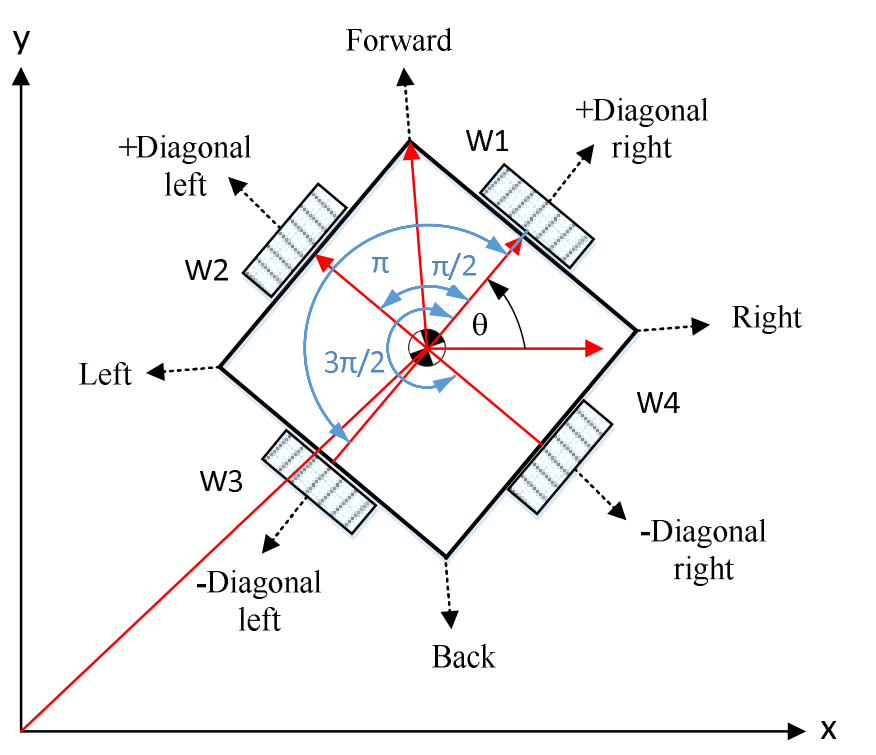

Fig. 1. The robot’s configuration and eight directions of motion 

The discrete-time dynamics follows,
$$
\begin{aligned}
& \dot{x}(t) = rwheel/2*(-\sin(\theta+\pi/4)*\omega_{1}(t)-\sin(\theta+3\pi/4)*\omega_{2}(t)-\sin(\theta+5\pi/4)*\omega_{3}(t)-\sin(\theta+7\pi/4)*\omega_{4}(t)) \\
& \dot{y}(t) = rwheel/2*(\cos(\theta+\pi/4)*\omega_{1}(t)+\cos(\theta+3\pi/4)*\omega_{2}(t)+\cos(\theta+5\pi/4)*\omega_{3}(t)+\cos(\theta+7\pi/4)*\omega_{4}(t)) \\
& \dot{\theta}(t) = rwheel/2*(1/(2*rRobot)*\omega_{1}(t)+1/(2*rRobot)*\omega_{2}(t)+1/(2*rRobot)*\omega_{3}(t)+1/(2*rRobot)*\omega_{4}(t)), \\
& x(t+1) = x(t) + \dot{x}(t) \Delta t, \\
& y(t+1) = y(t) + \dot{y}(t) \Delta t, \\
& \theta(t+1) = \theta(t) + \dot{\theta}(t) \Delta t
& \end{aligned}
$$

where $\Delta t$ is a time interval. Further, let the closed-loop controller be 

$$
\textbf{u}(t) = [\omega_{1}, \omega_{2},\omega_{3},\omega_{4}] = \pi_{w}(\textbf{x}(t))
$$


where $\pi_{w}(\cdot)$ is a neural network with parameters $w$, which are to be determined through optimization. 

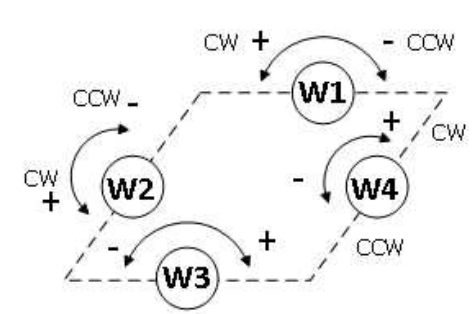

Fig. 2. The robot’s  action over 4 motion of wheels.

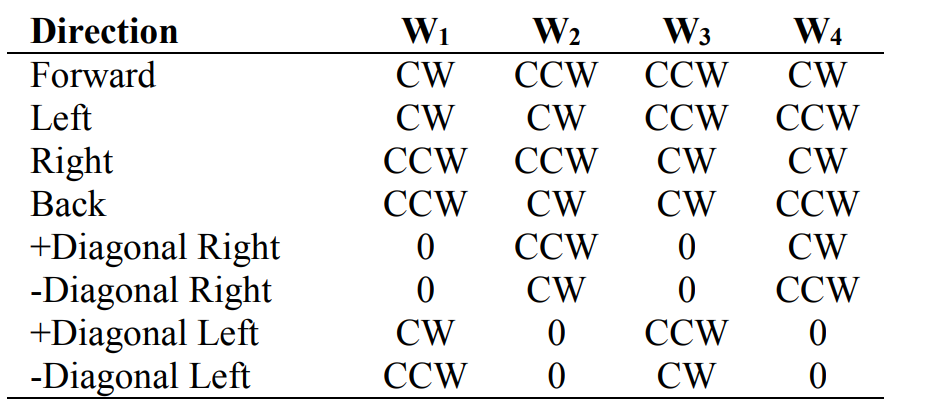

Table 1. Eight directions of the robot’s motion relate to the four wheels’ rotation direction.

For each time step, we assign a loss as a function of the control input and the state: $l(\textbf{x}(t),\textbf{u}(t))$. In this example, we will simply set $l(\textbf{x}(t),\textbf{u}(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(\textbf{x}(T),\textbf{u}(T)) = ||\textbf{x}(T)||^2$.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{w} \quad & \quad ||x(T)||^2 \\
\quad & \quad \dot{x}(t) = rwheel/2*(-\sin(\theta+\pi/4)*\omega_{1}(t)-\sin(\theta+3\pi/4)*\omega_{2}(t)-\sin(\theta+5\pi/4)*\omega_{3}(t)-\sin(\theta+7\pi/4)*\omega_{4}(t)) \\
\quad & \quad \dot{y}(t) = rwheel/2*(\cos(\theta+\pi/4)*\omega_{1}(t)+\cos(\theta+3\pi/4)*\omega_{2}(t)+\cos(\theta+5\pi/4)*\omega_{3}(t)+\cos(\theta+7\pi/4)*\omega_{4}(t)) \\
\quad & \quad \dot{\theta}(t) = rwheel/2*(1/(2*rRobot)*\omega_{1}(t)+1/(2*rRobot)*\omega_{2}(t)+1/(2*rRobot)*\omega_{3}(t)+1/(2*rRobot)*\omega_{4}(t)), \\
\quad & \quad x(t+1) = x(t) + \dot{x}(t) \Delta t, \\
\quad & \quad y(t+1) = y(t) + \dot{y}(t) \Delta t, \\
\quad & \quad \theta(t+1) = \theta(t) + \dot{\theta}(t) \Delta t \\
\quad & \quad \text{u}(t) = \pi_{w}(\textbf{x}(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $\textbf{x}(T-1)$ and $\textbf{u}(T-1)$, where $\textbf{x}(T-1)$ as a function of $\textbf{x}(T-2)$ and $\textbf{u}(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $w$. 

In the following, we code the forward pass of the loss using [PyTorch](https://pytorch.org/), which then automatically computes the gradient $\nabla_{w} l(\textbf{x}(T),\textbf{u}(T))$.

---

## 2. Code

Before start, please make sure you install the PyTorch package in Python. If you are using Pycharm, you can do so through *setting*->*Project: Your Project Name*->*Project Interpreter*->*Install (the little plus sign to the right of the window)*. 

In [676]:
# Code updated and uploded at the following link: https://github.com/naren200/DesignOptimization/tree/master/Project-OminiWheelMovement

# overhead
import logging
import math
import random
import numpy as np
import time
import torch 
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

!pip install ipywidgets
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter
rc('animation', html='jshtml');
!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)
import matplotlib.patches as patches
logger = logging.getLogger(__name__)

Here we set up some global constants for the dynamical model. FRAME_TIME represents the time resolution of the simulation.

In [690]:
# Environment parameters
FRAME_TIME = 0.1  # Time interval between frames
BOOST_ACCEL = 0.28  # Constant for thrust acceleration
OMEGA_RATE = 0.1  # Maximum rotation rate

# Robot dimensions
r_wheel = 0.1  # Radius of the wheel
R_robot = 0.7  # Radius of the robot


Here we set up the dynamical model in Pytorch. The dynamics is written as the forward pass of a neural network (``nn.Module``) so that it becomes a part of a differentiable computational graph. Note: This is the part that requires a lot of patience and care!

Some explanation: 

* ``action_tensor`` is $[\omega_{1}(t), \omega_{2}(t),\omega_{3}(t),\omega_{4}(t)]$
* ``x(t)`` is $[\dot{x}(t), \dot{y}(t), \dot{\theta}(t), x(t), y(t), \theta(t)]$
* the state of $t+1$ is denoted by ``state`` and its elements are updated by

$$
\textbf{x}(t+1) = \left[\begin{array}{llll}
1 & 0 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0 & 0\\
\Delta t & 0 & 0 & 1 & 0 & 0\\
0 & \Delta t & 0 & 0 & 1 & 0\\
0 & 0 & \Delta t & 0 & 0 & 1\\ 
\end{array}\right]\textbf{x}(t) + rwheel/2*
\left[\begin{array}{llll}
-\sin(\theta+\pi/4) & -\sin(\theta+3\pi/4 & -\sin(\theta+5\pi/4) & -\sin(\theta+7\pi/4) \\
\cos(\theta+\pi/4) & \cos(\theta+3\pi/4 & \cos(\theta+5\pi/4) & \cos(\theta+7\pi/4) \\
1/(2*rRobot) & 1/(2*rRobot) & 1/(2*rRobot) & 1/(2*rRobot) \\
0 & 0 & 0 & 0  \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 
\end{array}\right] * (action~tensor)
$$

The above implementation seems quite unnecessary, but it is done so because to build a differentiable graph, Pytorch does not allow direct editing on individual tensor elements. 

In [678]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        Parameters:
        - state: Tensor, representing the current state of the robot.
                 [vx, vy, omega_robot, x, y, theta_robot]

        - action: Tensor, representing control inputs.
                  [w1, w2, w3, w4]

        Note: The indexing convention for state and action is explained in the docstring.

        action[0] = w1
        action[1] = w2
        action[2] = w3
        action[3] = w4

        state[0] = vx
        state[1] = vy
        state[2] = omega_robot
        state[3] = x
        state[4] = y
        state[5] = theta_robot

        """
        
        # Extracting the integer part of theta_robot to handle multiple revolutions
        n = abs(int(state[0][5]/(2*math.pi)))
        theta = state[0][5] - n *2* math.pi

        # Update J_mat - Jacobian matrix
        J_mat = BOOST_ACCEL * r_wheel/2 * torch.tensor([[-math.sin(theta+math.pi/4), math.sin(theta+3*math.pi/4),math.sin(theta+5*math.pi/4), math.sin(theta+7*math.pi/4)],
                                        [math.cos(theta+math.pi/4), math.cos(theta+3*math.pi/4), math.cos(theta+5*math.pi/4), math.cos(theta+7*math.pi/4)],
                                        [1/(2*R_robot), 1/(2*R_robot), 1/(2*R_robot), 1/(2*R_robot)],
                                        [0., 0., 0., 0.],
                                        [0., 0., 0., 0.],
                                        [0., 0., 0., 0.]])
        
        # Shift matrix for updating the state
        shift_mat = torch.tensor([[1., 0., 0., 0., 0., 0.],
                                 [0., 1., 0., 0., 0., 0.],
                                 [0., 0., 1., 0., 0., 0.],
                                 [FRAME_TIME, 0., 0., 1., 0., 0.],
                                 [0., FRAME_TIME, 0., 0., 1., 0.],
                                 [0., 0., FRAME_TIME, 0., 0., 1.]])
        
        # Update the state using the shift matrix and Jacobian matrix
        state = torch.matmul(shift_mat, state.T) + torch.matmul(J_mat, action.T) # + torch.matmul(shift_mat, delta_state_gravity.T)  * 0.5

        # Transpose the state back to its original form
        state = state.T

        return state

Now we define a controller using another neural network. The network takes in the 5 state variables and outputs 2 action variables. The one we use here has two hidden layers with ``Tanh`` activation. The output layer uses ``Sigmoid`` activation so that the two output values are within 0 to 1. We then linearly transform the outputs so that the first variable (thrust) is ranged in 0 to 2, and the second variable (angular velocity) is ranged in -1 to 1 (so that the rocket can tilt in both directions).

In [679]:
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        Neural network-based controller for the robot.

        Parameters:
        - dim_input: Number of system states.
        - dim_output: Number of actions.
        - dim_hidden: Dimension of the hidden layers.

        """
        
        super(Controller, self).__init__()

        # Define a neural network with multiple hidden layers and activation functions
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        """
        Forward pass through the neural network.

        Parameters:
        - state: Tensor, representing the current state of the robot.

        Returns:
        - action: Tensor, representing the output actions from the controller.

        """

        # Pass the state through the neural network
        action = self.network(state)

        # Adjust the output to bound the theta_dot of robot's wheel range between -1 and 1
        action = (action - torch.tensor([0.5, 0.5, 0.5, 0.5]))*2  

        return action
     

Now with the dynamical model and the controller, we can simulate the landing (or not landing) of the rocket. We set the initial state to $[0, 4, 0, 0, 0]$ (initial altitude = 4). Using ``action = self.controller(state)`` we get an action from the initial state, and using ``state = self.dynamics(state, action)`` we get the next state from the action. This is iterated for ``T`` steps, at the end of which we compute the ``error`` to be minimized with respect to the controller weights.

Some comments:
* The controller optimized this way will be specific to the given initial state. It is, however, more reasonable to design a controller that works for a range of initial states. This can be approximately done by optimizing the errors for a batch of initial states rather than one. Modern programming language such as Pytorch, Tensorlow, JAX, Julia all support parallel tensor computation and thus can easily extend our current implementation to the batch mode.
* A more formal way of computing a feedback controller for a set of initial states would be to solve Hamilton-Jacobi-Bellman equation, which can be formulated as a different optimization problem. When dynamics is unknown or partially known, we usually resort to model-based or model-free reinforcement learning.
* It is often necessary to fine-tune the weights on each loss terms, e.g., if landing with zero velocity is critical, then one might need to put high weights on $\dot{y}(t)$ to force it to 0.

In [692]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        """
        Simulates the behavior of a robot using a given controller and dynamics model.

        Parameters:
        - controller: Controller module responsible for generating actions.
        - dynamics: Dynamics module responsible for updating the robot's state based on actions.
        - T: Number of time steps to simulate.

        """

        super(Simulation, self).__init__()

        # Initialize the robot state, controller, dynamics, simulation duration, and trajectory variables
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        """
        Perform a simulation over T time steps using the specified controller and dynamics.

        Parameters:
        - state: Tensor, representing the initial state of the robot.

        Returns:
        - error: Scalar Tensor, representing the error of the simulated trajectory.

        """

        self.action_trajectory = [] # List to store actions at each time step
        self.state_trajectory = []  # List to store states at each time step

        # Simulate the robot's behavior for T time steps
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        # Calculate and return the error of the final state
        return self.error(state)

    @staticmethod
    def initialize_state():
        """
        Initialize the state of the robot.

        Returns:
        - state: Tensor, representing the initial state of the robot.

        """
        state = [[0., 0., 0., 4., 3.,0.]]
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):
        """
        Calculate the error of the simulated trajectory based on a predefined weight.

        Parameters:
        - state: Tensor, representing the final state of the robot.

        Returns:
        - error: Scalar Tensor, representing the error of the trajectory.

        """

        # Define a weight vector for each state variable
        weight=torch.tensor([[1.,1.,1.,5.,6.,3.]])
        # Calculate the mean squared error using the weighted difference between the simulated state and a target state
        return  torch.mean(((state-fs)*weight)**2)
        # Alternative: Return the mean squared error with a different weighting
        # return torch.mean(((state - fs) * torch.tensor([[5., 5., 1., 1., 0.]]))**2)

    

Now that we have built the computational graph for the error to be minimized, we can compute the gradient of the error with respect to the controller weights and apply gradient-based algorithms to minimize the error. The particular algorithm we adopt here is ``L-BFGS``, which is a quasi-Newton type of algorithm that uses a limited memory of past gradients to approximate the current Hessian (think about a first-order Taylor's expansion on the gradient itself). The algorithm also guarantees a positive definite Hessian approximation, allowing it to be applicable to non-convex problems.

Some comments:
* Gradient descent can also be applied here. Newton's method cannot since the problem is not convex.
* Here I use a fixed step size (or learning rate) ``lr = 0.01``. Adaptive step size or line search might help to improve the search efficiency.


In [681]:
class Optimize:

    # create properties of the class (simulation, parameters, optimizer, lost_list). Where to receive input of objects
    
    def __init__(self, simulation):
        """
        Optimization class to train a controller using the specified simulation.

        Parameters:
        - simulation: Simulation module representing the robot dynamics and controller.

        """
        self.simulation = simulation # Define the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01) # Define the opmization algorithm
        self.loss_list = [] # List to store losses during training
    
    # Define loss calculation method for objective function
    
    def step(self):
        """
        Perform a single optimization step.

        Returns:
        - loss: Scalar Tensor, representing the loss of the objective function.

        """
        def closure():
            loss = self.simulation(self.simulation.state)  # Calculate the loss of the objective function
            self.optimizer.zero_grad()
            loss.backward() #  Calculate the gradient
            return loss

        self.optimizer.step(closure)
        return closure()

    # Define training method for the model
    
    def Animation_Only(self):
        self.animation(self.epochs)

    def train(self, epochs):
        """
        Train the model for a specified number of epochs.

        Parameters:
        - epochs: Number of training epochs.

        """
        self.epochs = epochs
        # self.optimizer = epoch
        l = np.zeros(epochs)
        for epoch in range(epochs):
            self.epoch = epoch
            loss = self.step() # Use step function to train the model
            self.loss_list.append(loss) # Add loss to the loss_list
            print('[%d] loss: %.3f' % (epoch + 1, loss))

            l[epoch]=loss
            self.visualize()
            
        plt.plot(list(range(epochs)), l)
            
        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')
        plt.show()
        self.animation(epochs)
        
    # Define result visualization method

    def visualize(self):
        """
        Visualize the results of the optimization.

        """
        # Extract data from the simulation
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 3]
        y = data[:, 4]
        vx = data[:, 0]
        vy = data[:, 1]
        theta = data[:, 5]
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        w1 = action_data[:,0]
        w2 = action_data[:,1]
        w3 = action_data[:,2]
        w4 = action_data[:,3]
        frame = range(self.simulation.T)

        # Create subplots for visualization
        fig, ax = plt.subplots(2, 3, tight_layout = 1, figsize = (15, 7))

        # Displacement plot (x-y)
        ax[0, 0].plot(x, y, c = 'b')
        ax[0, 0].set_xlabel("X")
        ax[0, 0].set_ylabel("Y")
        ax[0, 0].set(title=f'Displacement plot(x-y) at frame {self.epoch}')

        # Velocity plot
        ax[1, 0].plot(frame, vx, c = 'c', label = "Velocity in x")
        ax[1, 0].plot(frame, vy, c = 'r', label = "Velocity in y")
        ax[1, 0].set_xlabel("Time")
        ax[1, 0].set_ylabel("Velocity (m/s)")
        ax[1, 0].legend(frameon=0)
        ax[1, 0].set(title =f'Velocity plot at frame {self.epoch}')
        
        # Action plots (w1, w2, w3, w4)
        ax[0, 1].plot(frame, w1, c = 'g', label = "w1")
        ax[0, 1].set_xlabel("Time interval")
        ax[0, 1].set_ylabel("w1")
        ax[0, 1].legend(frameon=0)
        ax[0, 1].set(title=f'w1 plot at {self.epoch}')

        ax[0, 2].plot(frame, w2, c = 'g', label = "w2")
        ax[0, 2].set_xlabel("Time interval")
        ax[0, 2].set_ylabel("w2")
        ax[0, 2].legend(frameon=0)
        ax[0, 2].set(title=f'w2 plot at {self.epoch}')

        ax[1, 1].plot(frame, w3, c = 'y', label = "w3")
        ax[1, 1].set_xlabel("Time interval")
        ax[1, 1].set_ylabel("w3")
        ax[1, 1].legend(frameon=0)
        ax[1, 1].set(title=f'w3 plot at {self.epoch}')

        ax[1, 2].plot(frame, w4, c = 'y', label = "w4")
        ax[1, 2].set_xlabel("Time interval")
        ax[1, 2].set_ylabel("w4")
        ax[1, 2].legend(frameon=0)
        ax[1, 2].set(title=f'w4 plot at {self.epoch}')

        plt.show()


    def animation(self, epochs):
        """
        Generate an animation of the robot's movement.

        Parameters:
        - epochs: Number of epochs for the animation.

        """

        # Constants for visualization
        length = 0.05          # m
        wheelLength = length/2
        width = 0.02          # m


        v_exhaust = 1     
        print("Generating Animation")
        steps = self.simulation.T + 1
        final_time_step = round(1/steps,6)
        f = IntProgress(min = 0, max = steps)
        display(f)

        # Extract data from the simulation
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])

        x_t = data
        u_t = action_data
        print(x_t.shape, u_t.shape)

        # Create a figure for the animation
        fig = plt.figure(figsize = (5,8), constrained_layout=False)
        ax1 = fig.add_subplot(111)
        
        ln1, = ax1.plot([], [], linewidth = 10, color = 'lightblue') # Robot body
        ln6, = ax1.plot([], [], '--', linewidth = 1, color = 'orange') # trajectory line
        ln2, = ax1.plot([], [], linewidth = 2, color = 'tomato') # thrust line
        # ln2, = ax1.plot([], [], linewidth = 4, color = 'tomato') # thrust line
        ln7, = ax1.plot([], [], linewidth = 10, color = 'lightblue') # Robot body

        plt.tight_layout()
        
        ax1.set_xlim(-5, 5)
        ax1.set_ylim(-2, 5)
        ax1.set_aspect(1)  # Aspect of the axis scaling, i.e., the ratio of y-unit to x-unit

        # Initial configuration for rocket visualization
        rocket_theta = fs[0, 5]
        rocket_x = fs[0, 3]

        # length/1 is just to make rocket bigger in animation
        rocket_x_points = [rocket_x + length/1 * np.sin(rocket_theta), rocket_x - length/1 * np.sin(rocket_theta)]
        
        rocket_y = fs[0, 4]
        
        rocket_y_points = [rocket_y + length/1 * np.cos(rocket_theta), rocket_y - length/1 * np.cos(rocket_theta)]
        
        # Set the initial data for the rocket visualization
        ln7.set_data(rocket_x_points, rocket_y_points)


        def update(i):
            # Update the rocket's position and velocity for each frame
            rocket_theta = x_t[i, 5]
            
            rocket_x = x_t[i, 3]
            # length/1 is just to make rocket bigger in animation
            rocket_x_points = [rocket_x + length/1 * np.sin(rocket_theta), rocket_x - length/1 * np.sin(rocket_theta)]
            
            rocket_y = x_t[i, 4]
            
            rocket_y_points = [rocket_y + length/1 * np.cos(rocket_theta), rocket_y - length/1 * np.cos(rocket_theta)]
            
            # Update the visualization of the rocket body
            ln1.set_data(rocket_x_points, rocket_y_points)

            # Calculate and update the velocity vector for visualization
            vel_length_v_x = x_t[i, 0]
            vel_length_v_y = x_t[i, 1]
            velocity_theta = math.atan(x_t[i,1]/x_t[i,0])

            # flame_x_points = [rocket_x_points[1], rocket_x_points[1] + flame_length * np.sin(thrust_angle - rocket_theta)]
            # flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * np.cos(thrust_angle - rocket_theta)]
            vel_x_points = [rocket_x_points[1], rocket_x_points[1] + vel_length_v_x * np.sin(velocity_theta)]
            vel_y_points = [rocket_y_points[1], rocket_y_points[1] + vel_length_v_y * np.cos(velocity_theta)]

            # Update the visualization of the velocity vector
            ln2.set_data(vel_x_points, vel_y_points)

            # Update the trajectory line in the animation
            ln6.set_data(x_t[:i, 3], x_t[:i, 4])

            # Update the progress bar
            f.value += 1

        # Set the playback speed for the animation
        playback_speed = 5000 # The higher, the slower the animation
        # Create the animation using FuncAnimation
        anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * playback_speed)

        # Save the animation as a GIF
        writer = PillowWriter(fps=20)
        anim.save("OminiMovement.gif", writer=writer)





Now we have almost everything set up. We will just need to put in some hyperparameters and let the code run!

[1] loss: 84.189


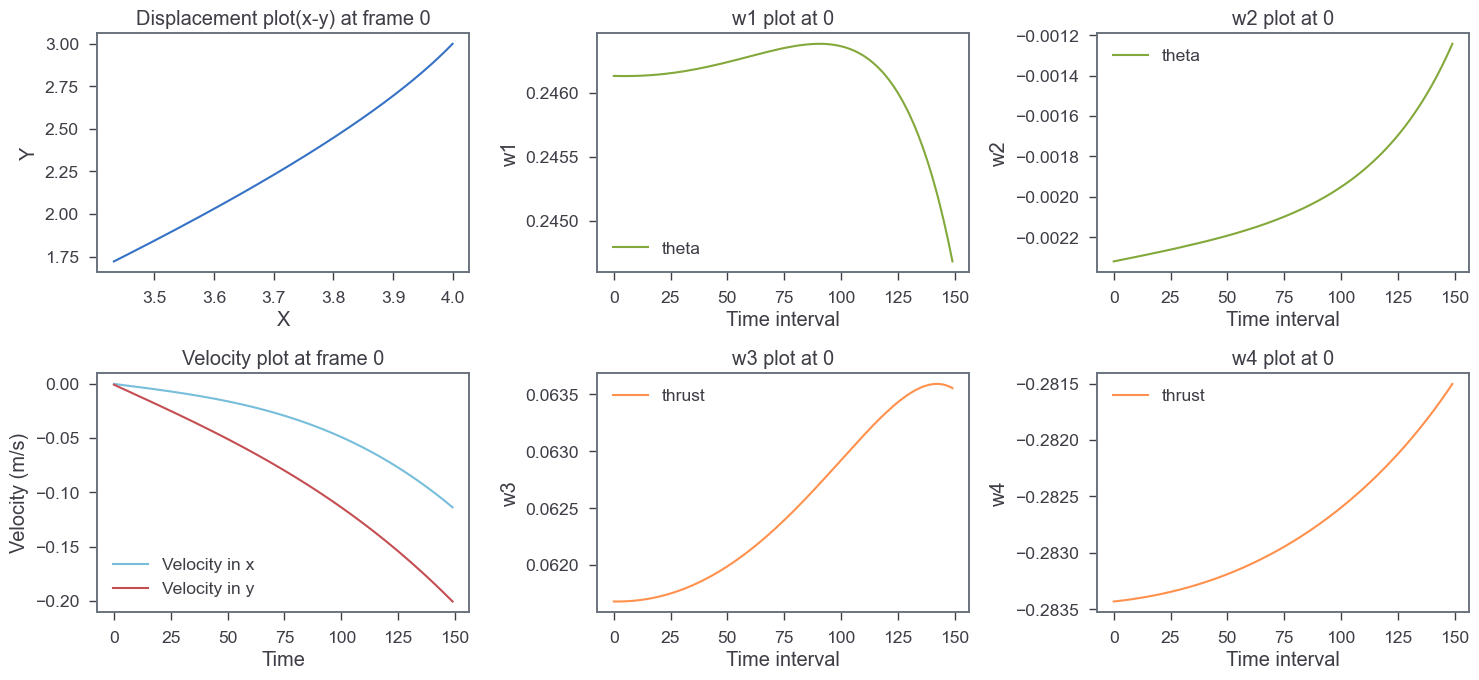

[2] loss: 27.271


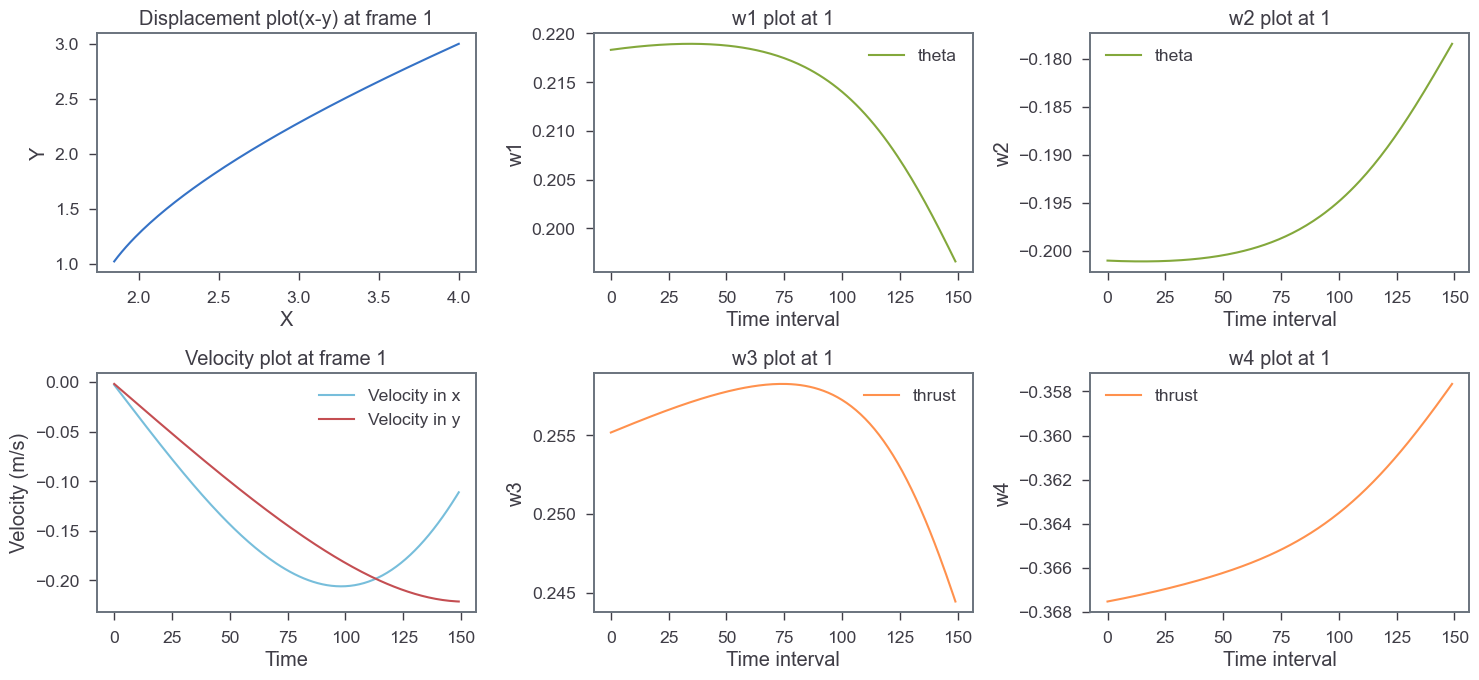

[3] loss: 10.734


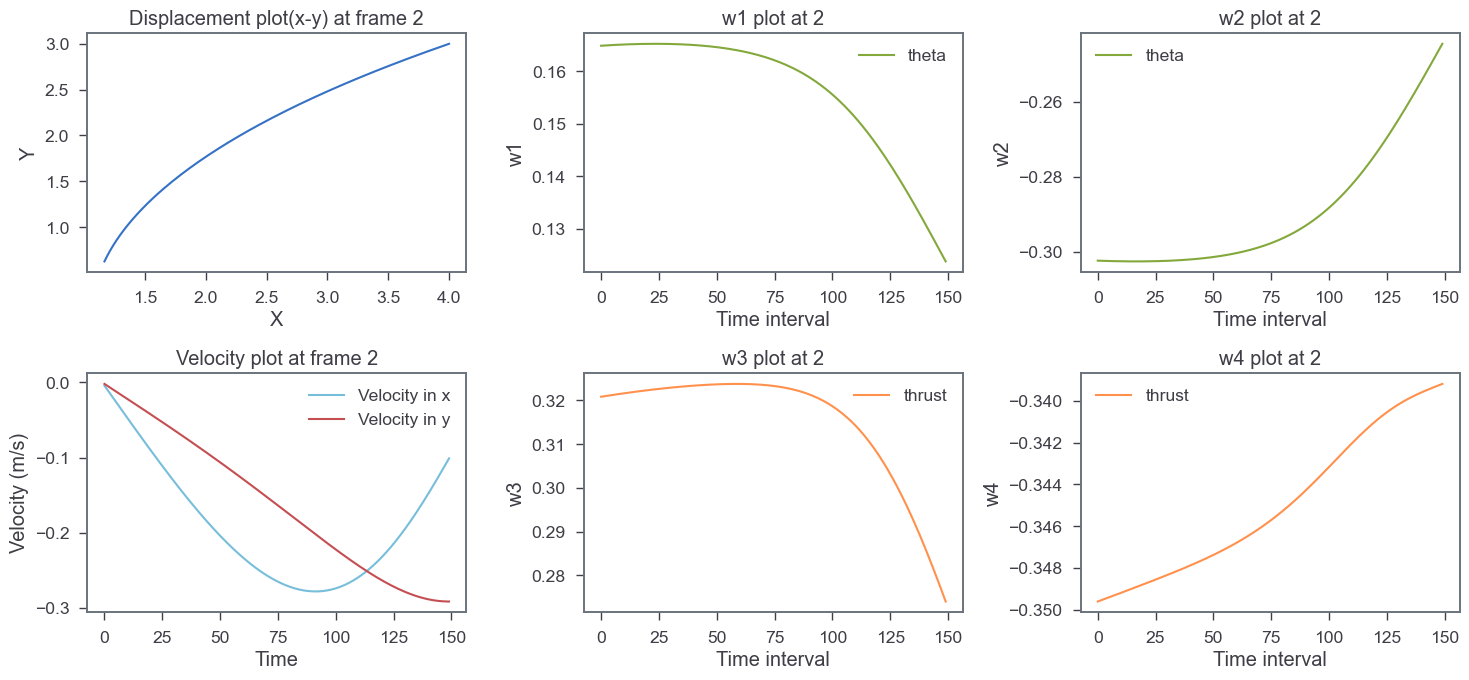

[4] loss: 4.522


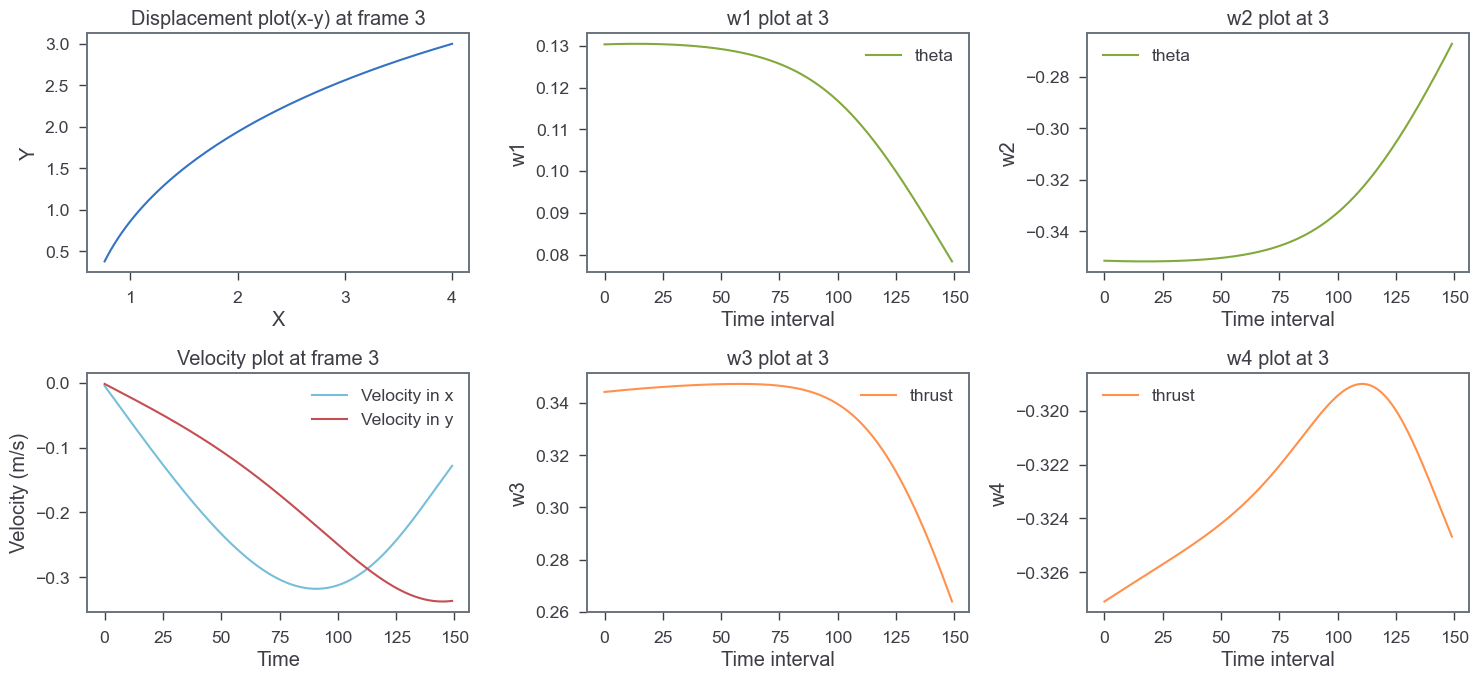

[5] loss: 2.246


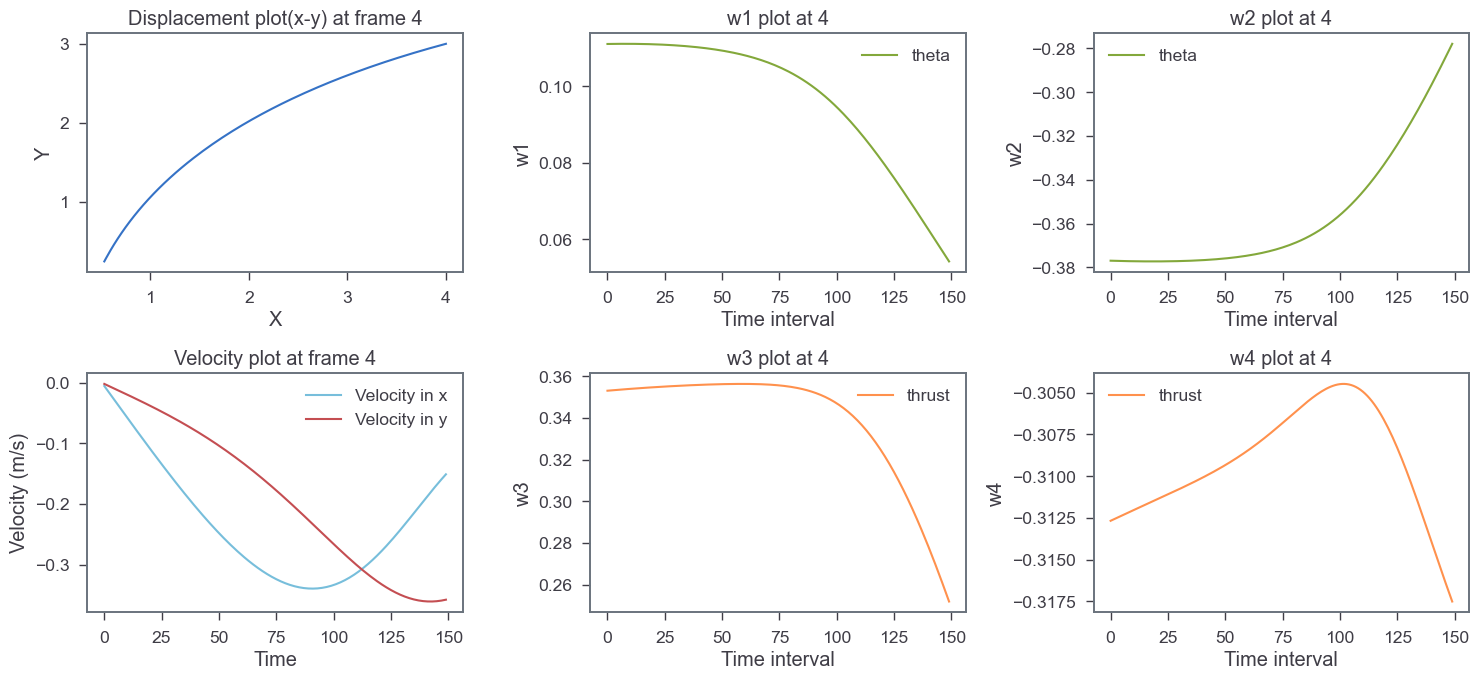

[6] loss: 1.241


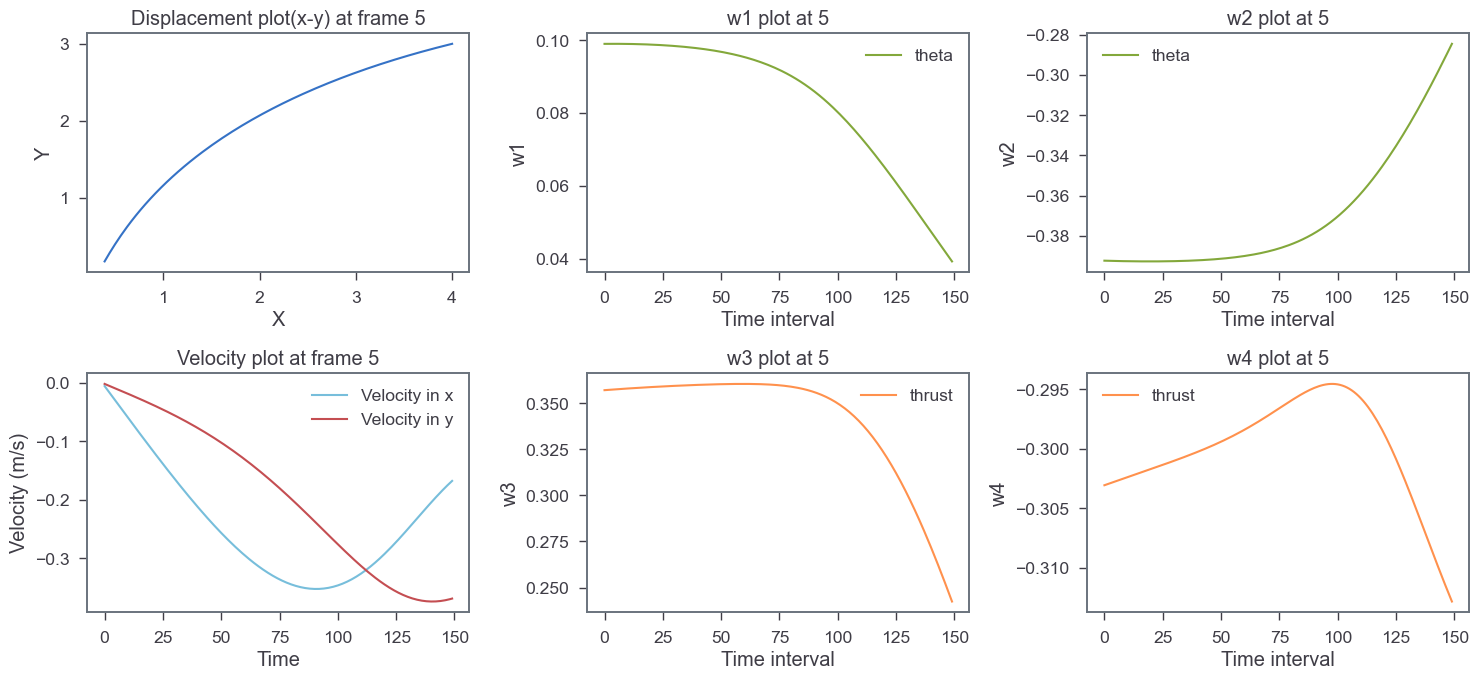

[7] loss: 0.734


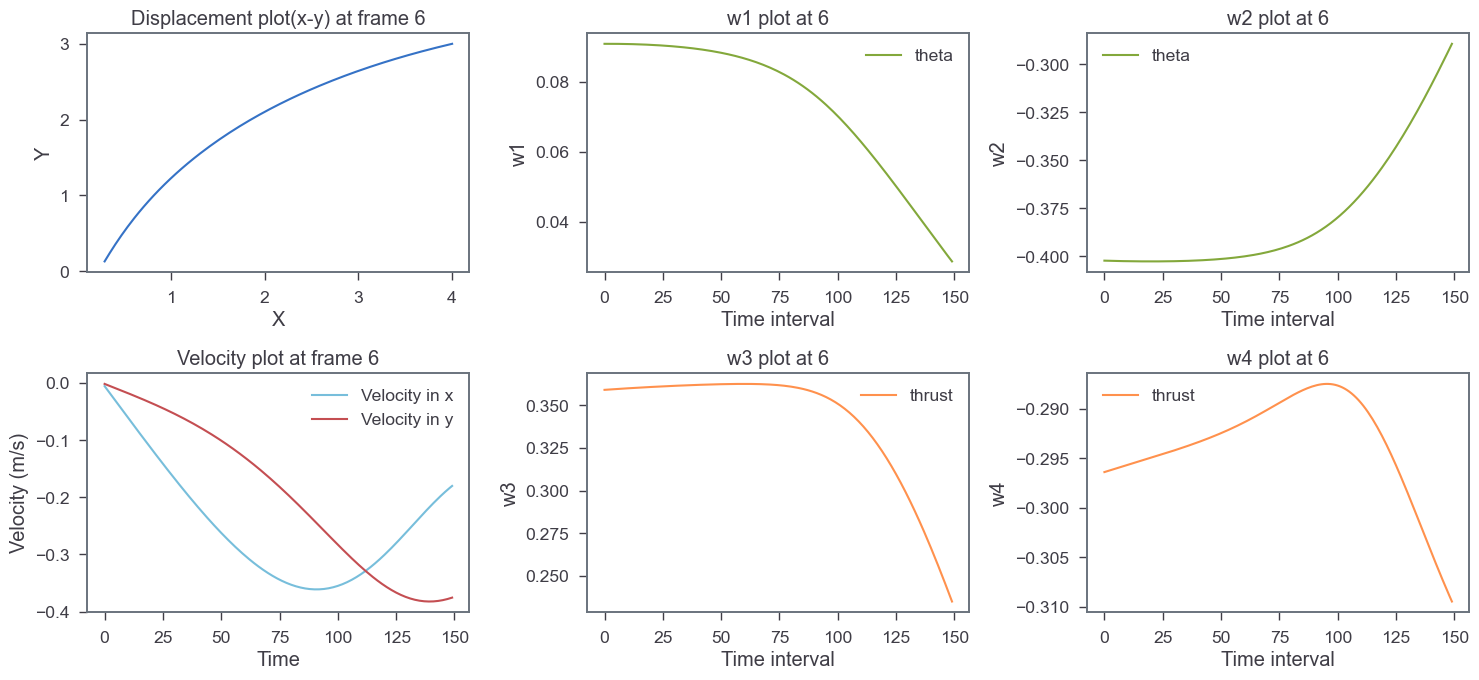

[8] loss: 0.448


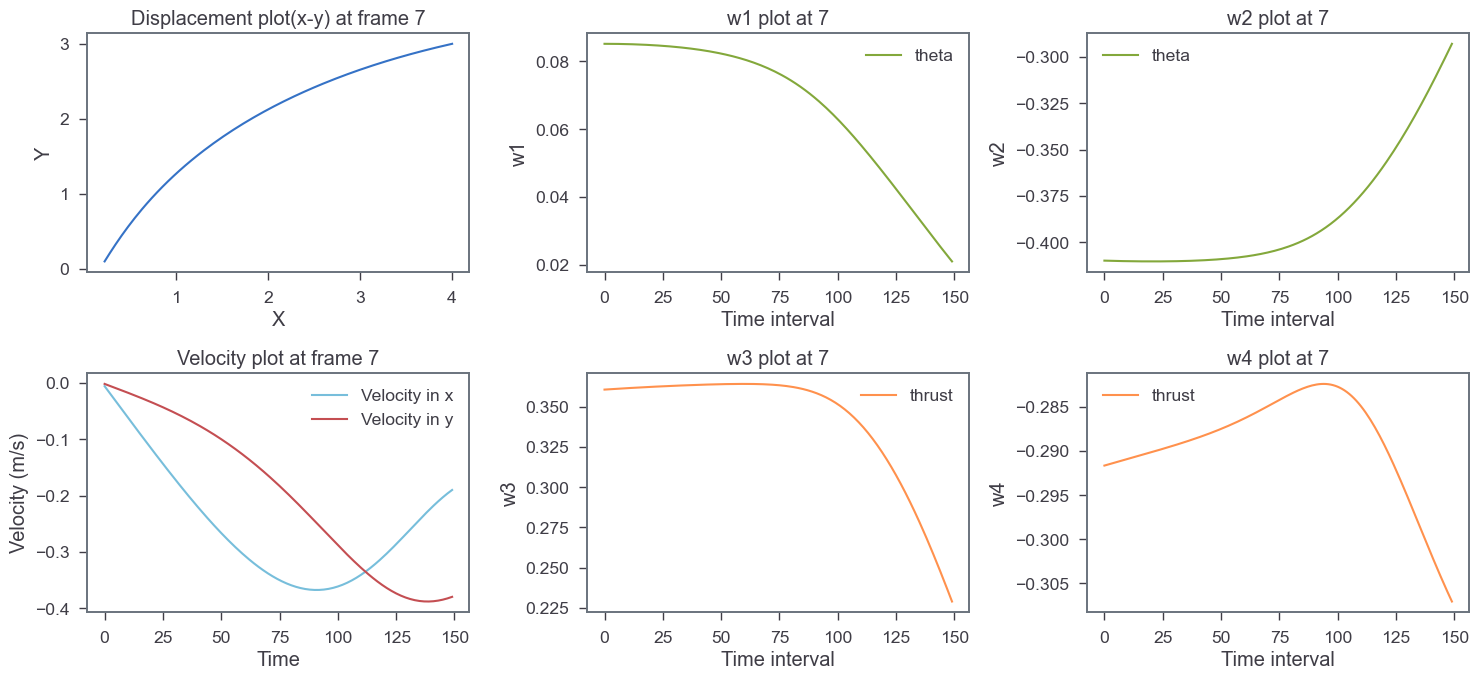

[9] loss: 0.296


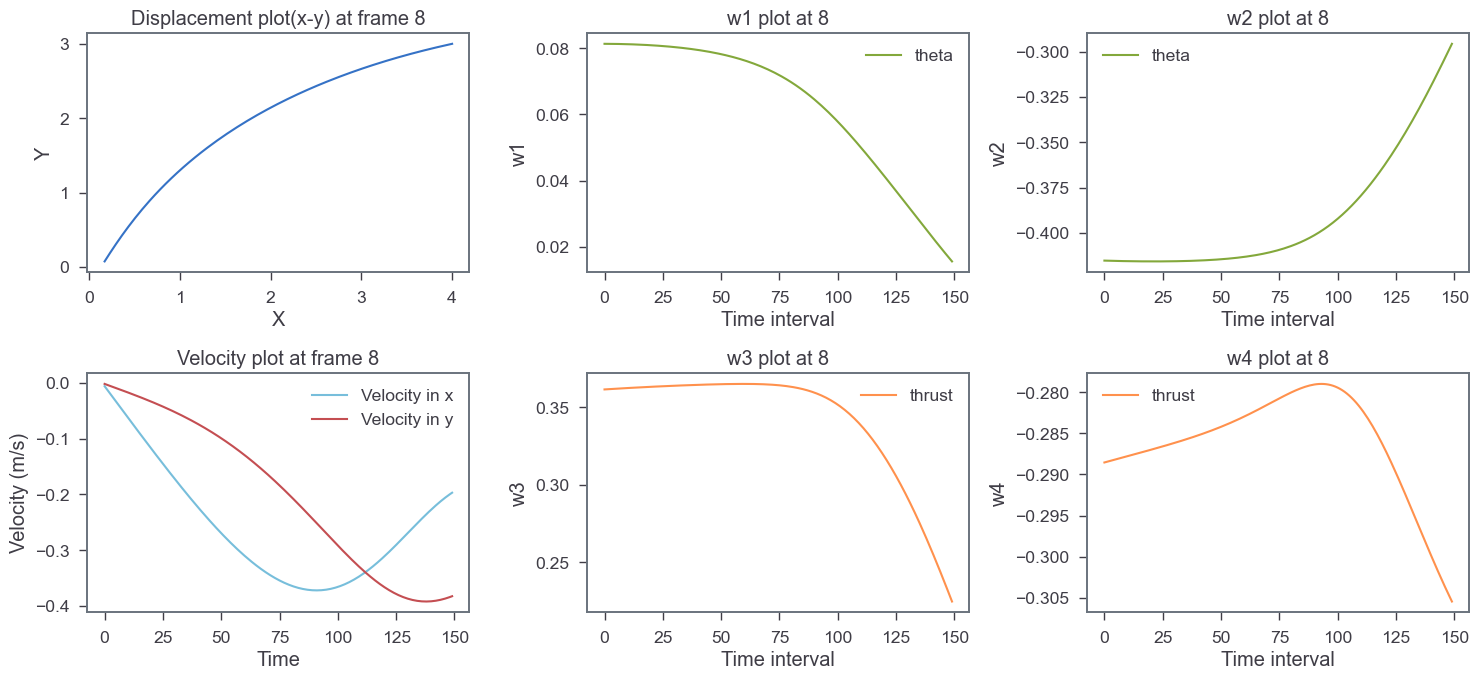

[10] loss: 0.204


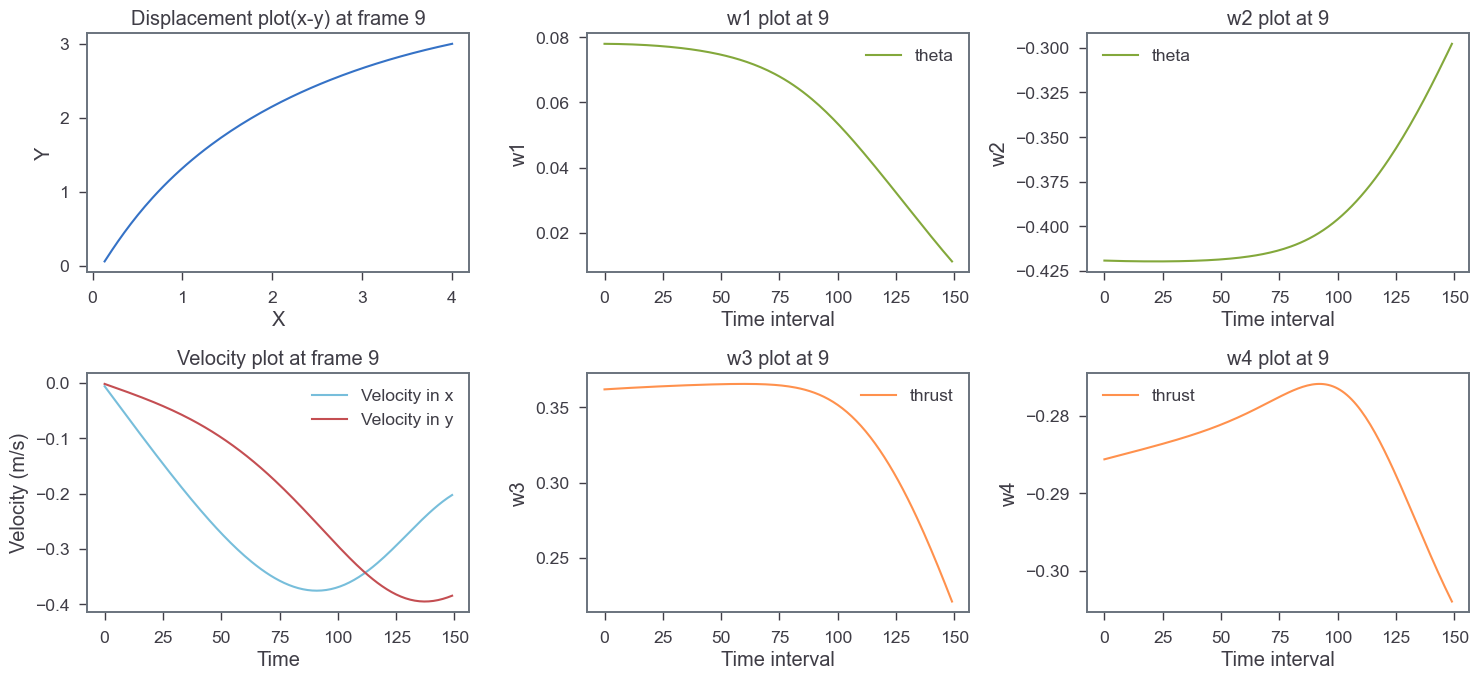

[11] loss: 0.146


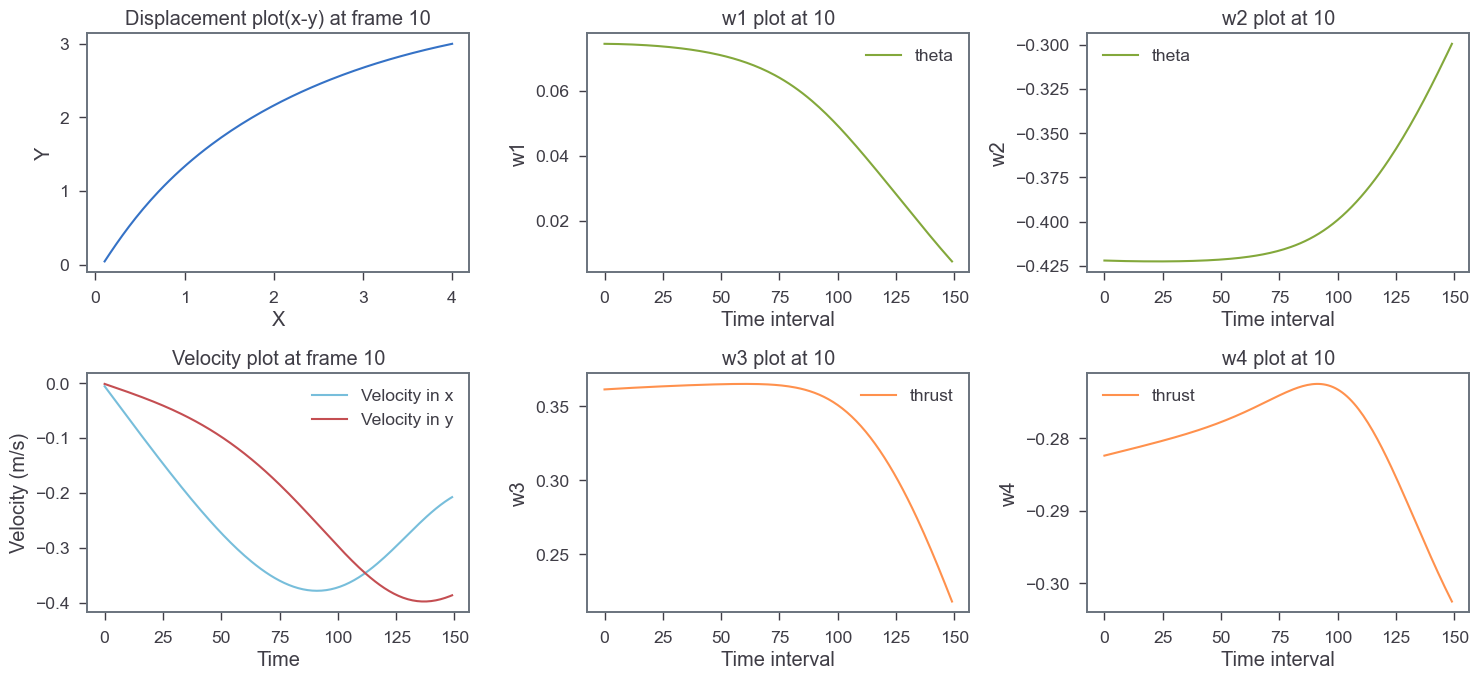

[12] loss: 0.111


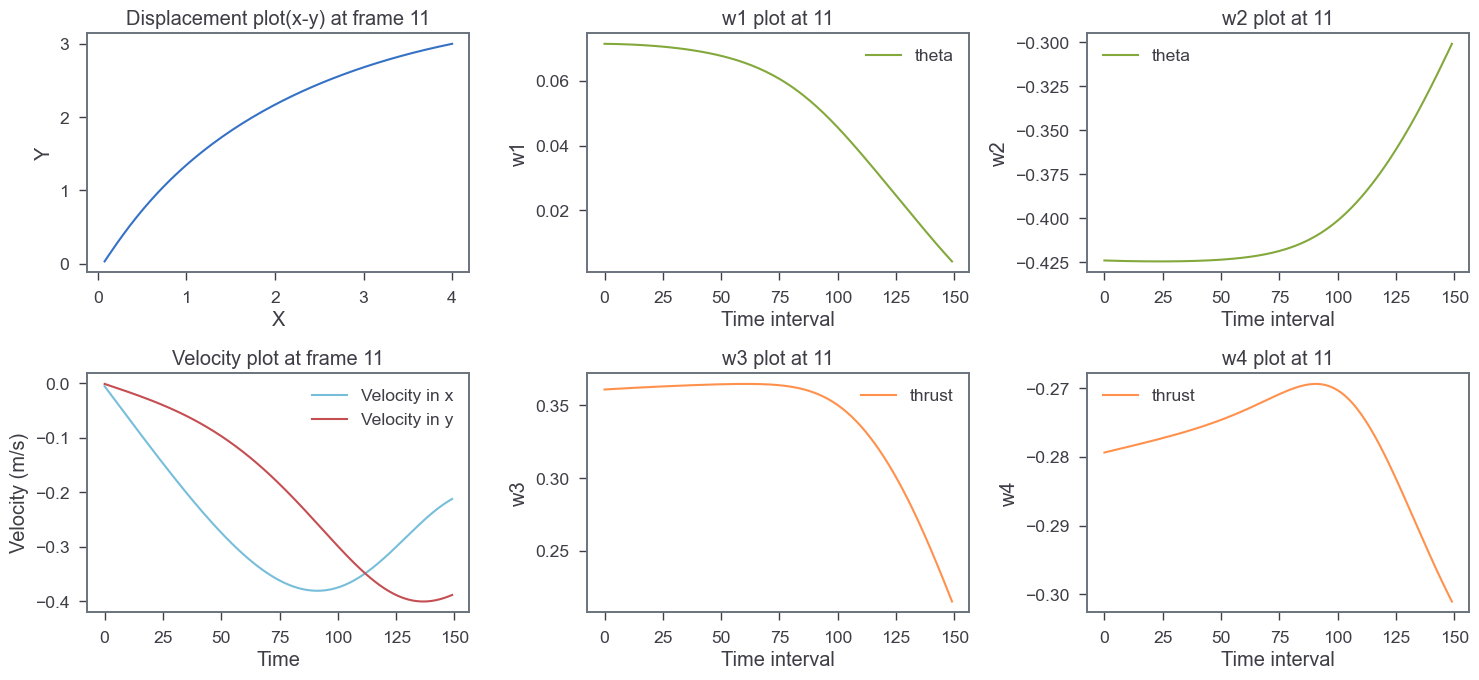

[13] loss: 0.092


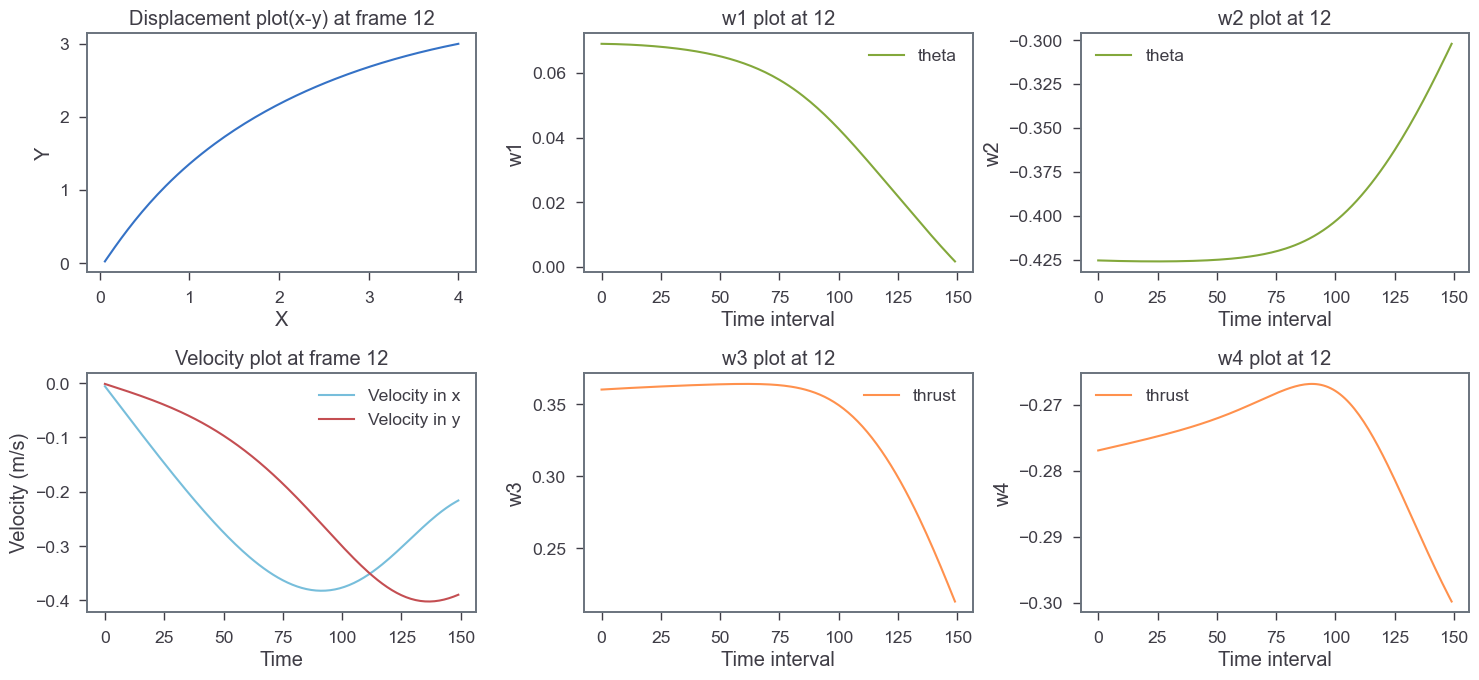

[14] loss: 0.081


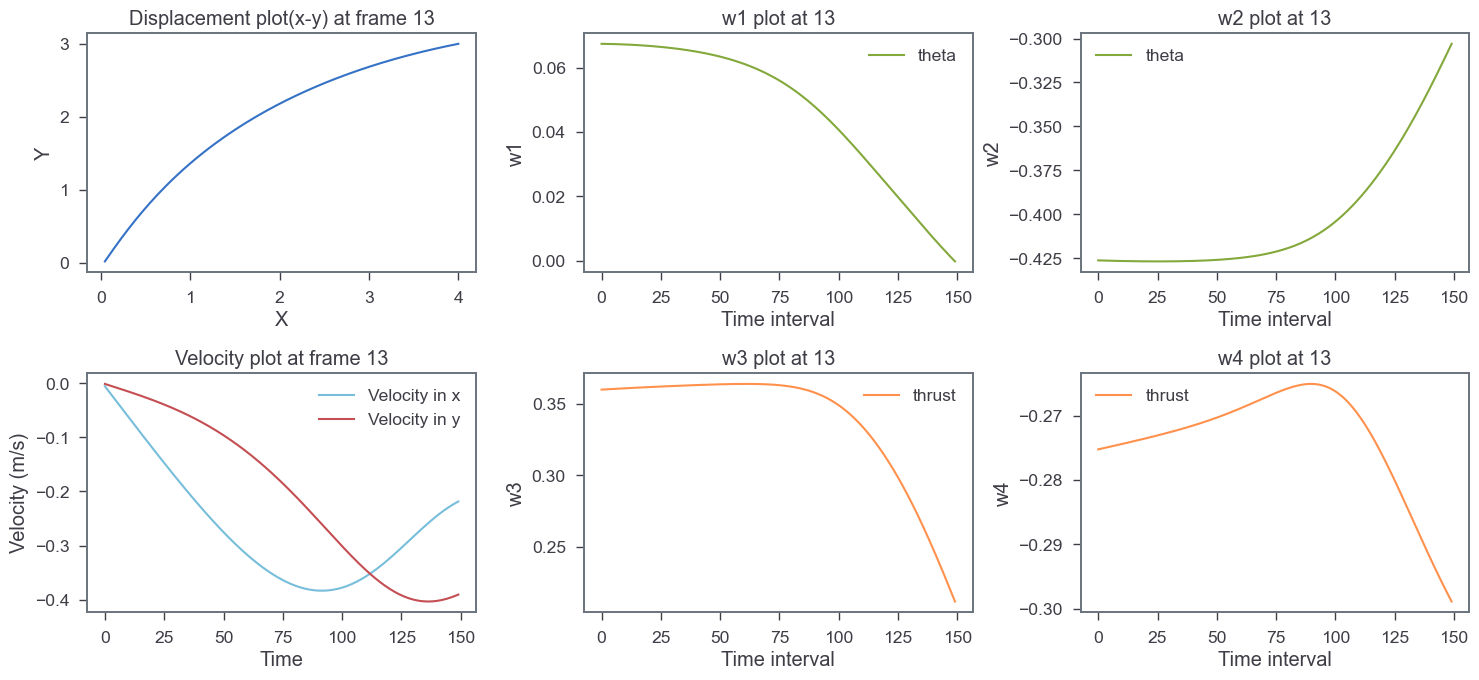

[15] loss: 0.076


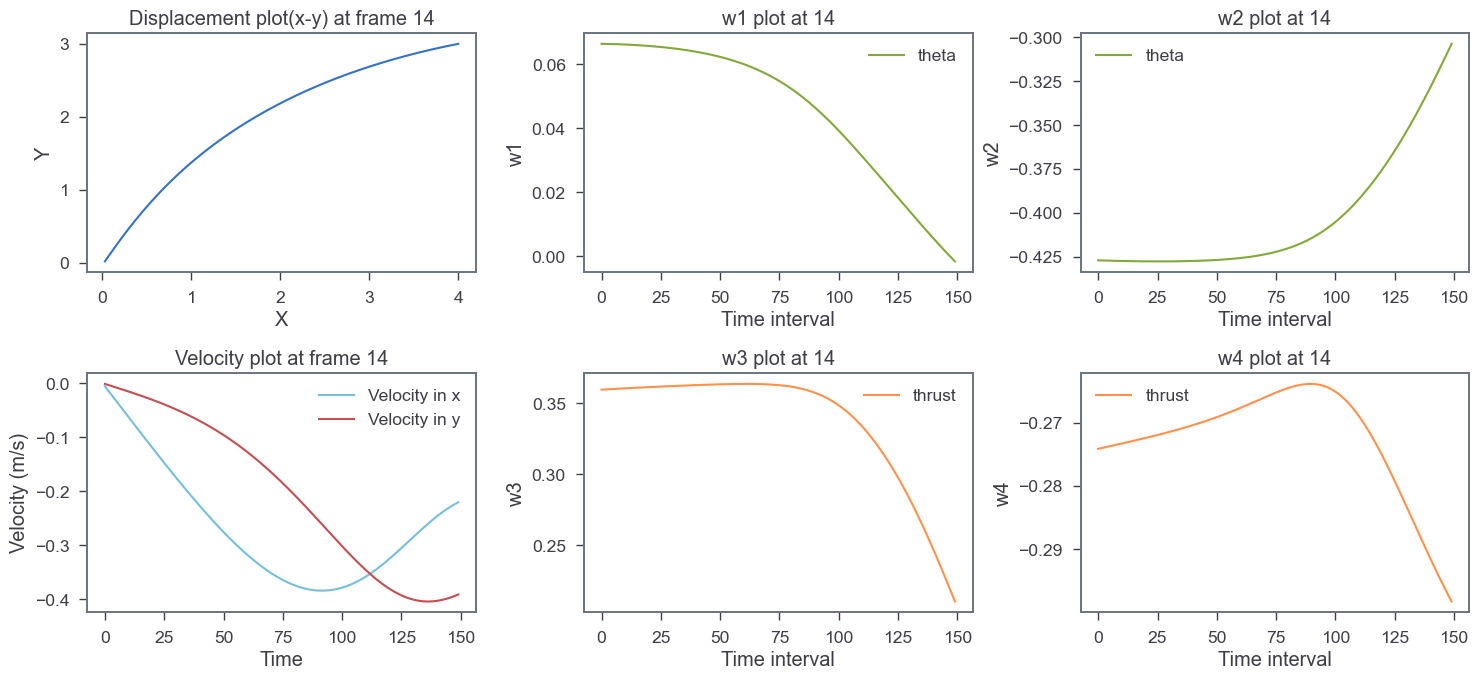

[16] loss: 0.072


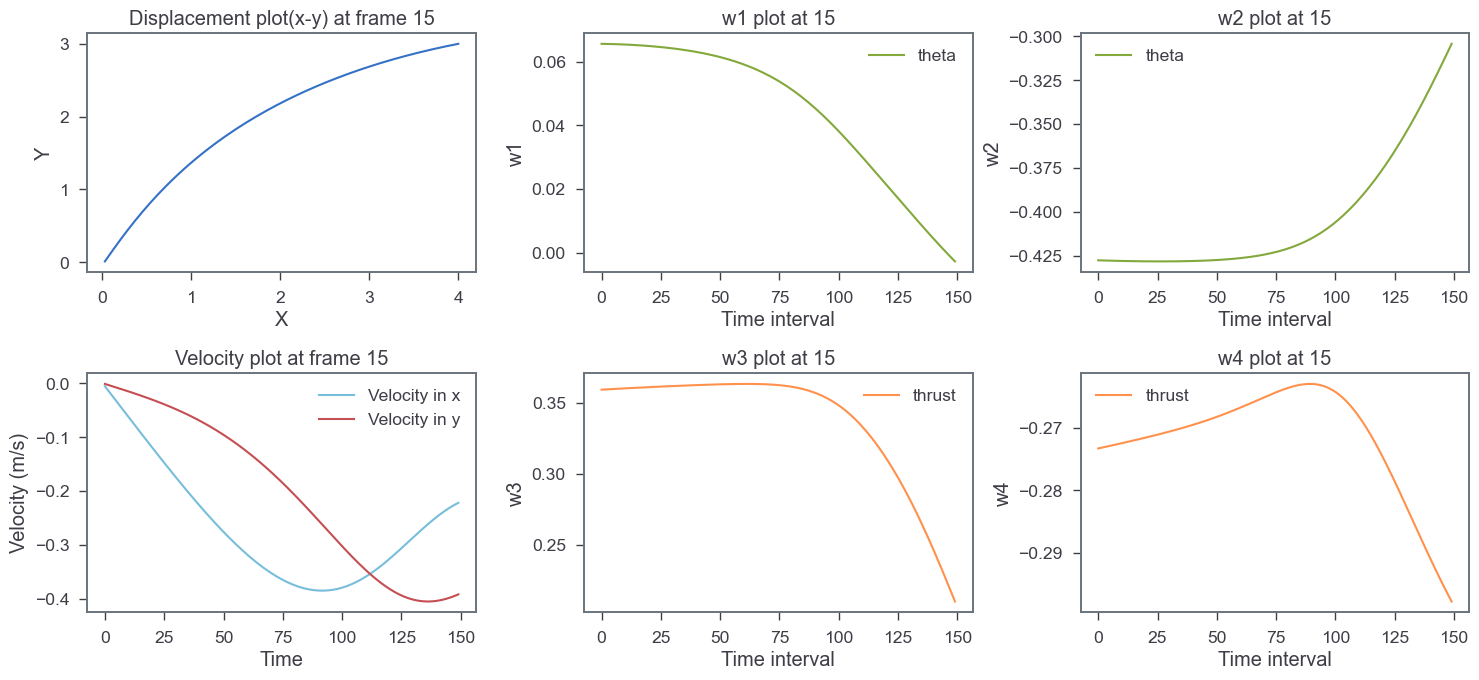

[17] loss: 0.070


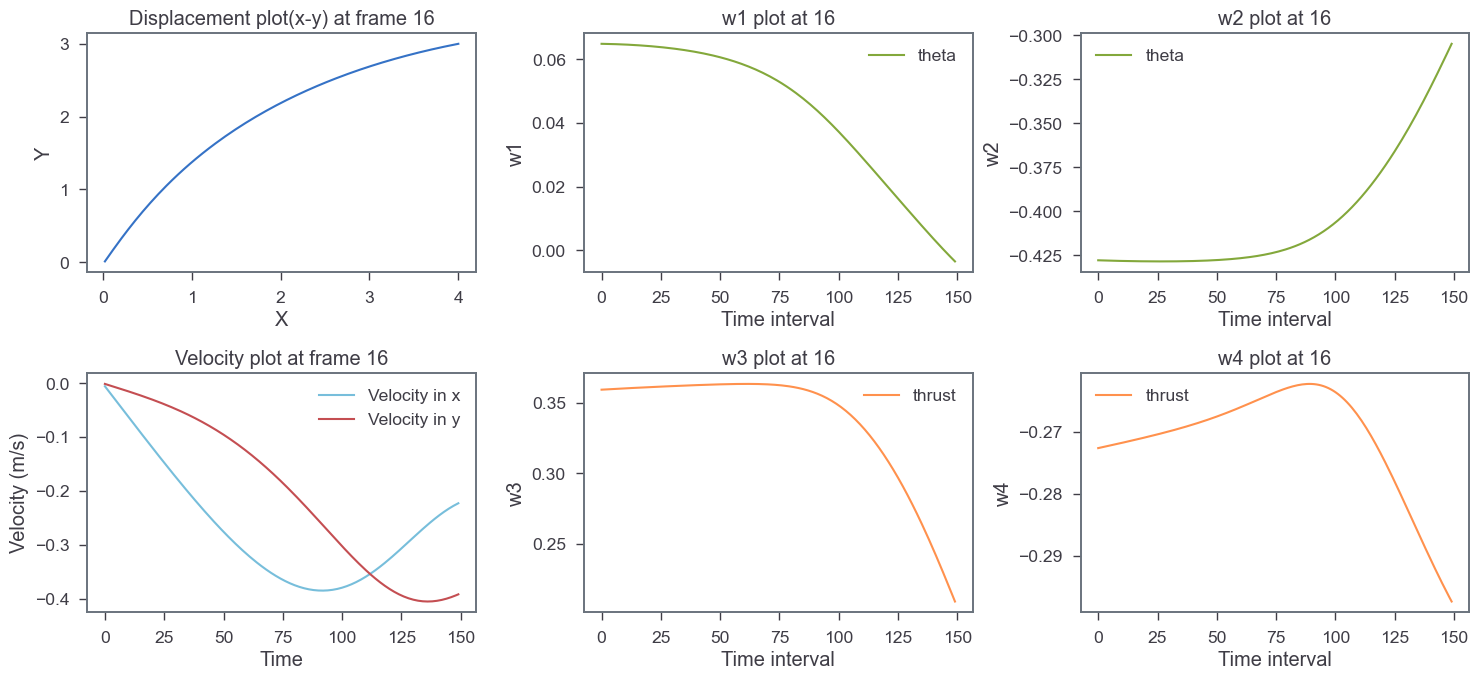

[18] loss: 0.069


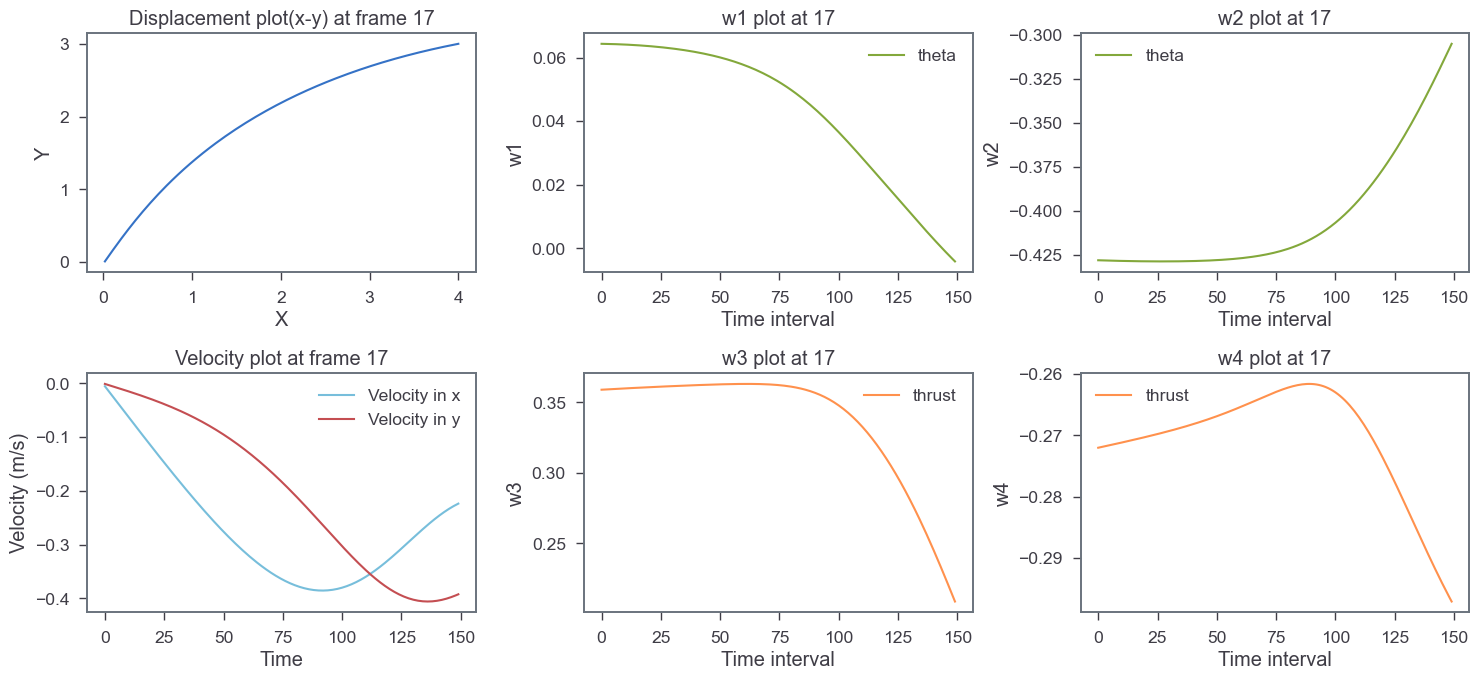

[19] loss: 0.069


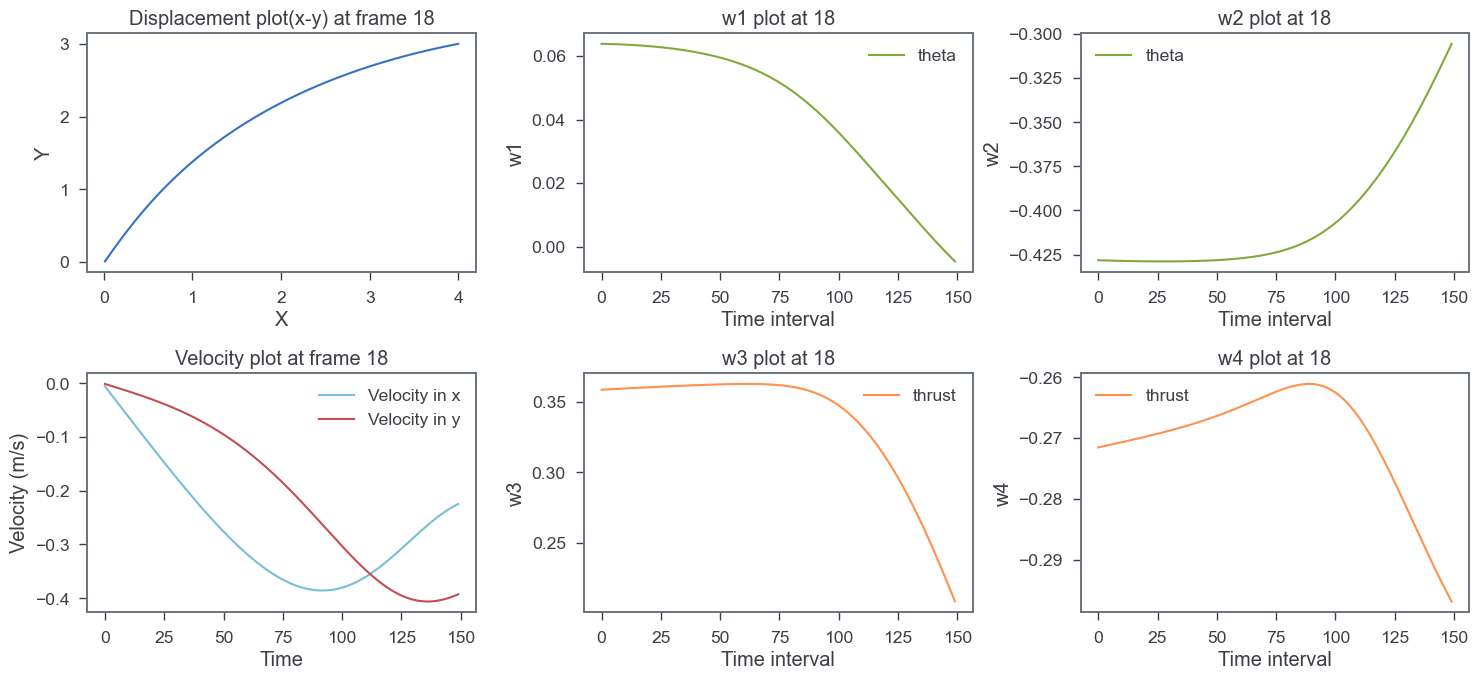

[20] loss: 0.068


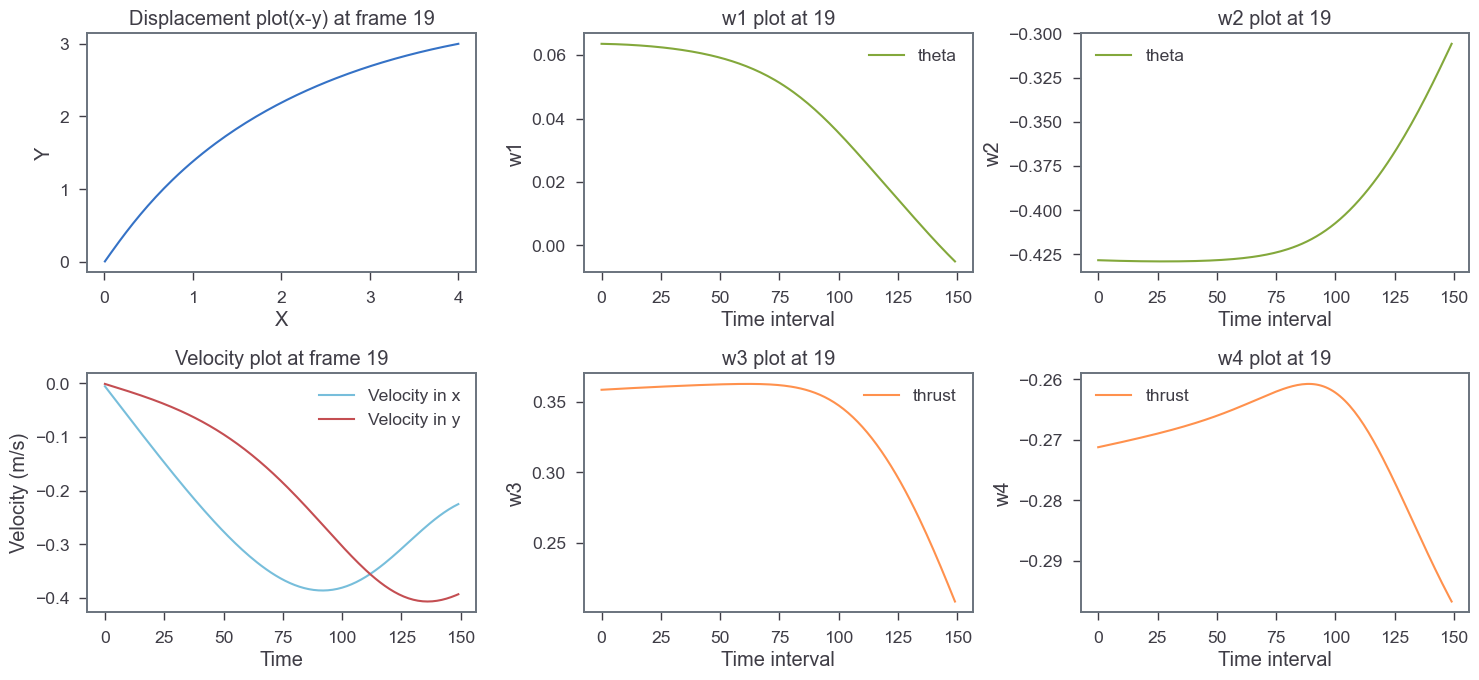

[21] loss: 0.068


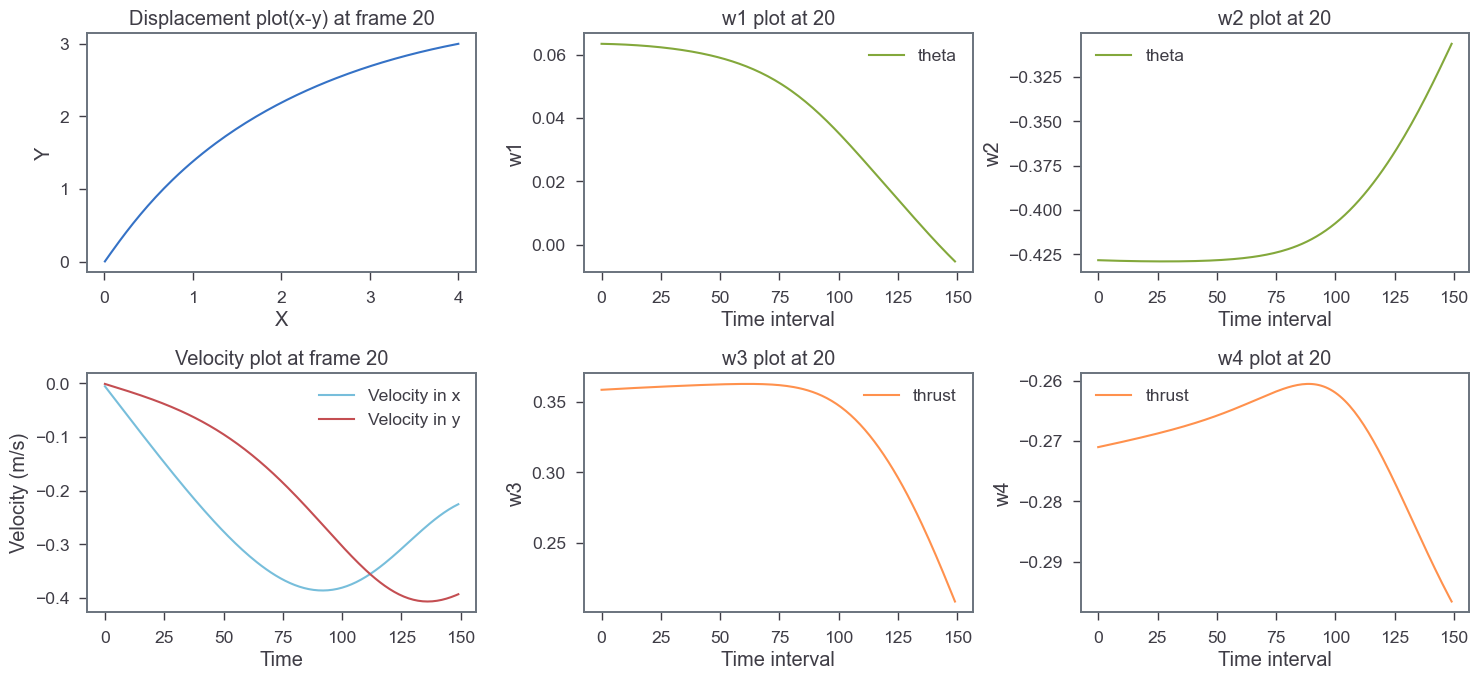

[22] loss: 0.068


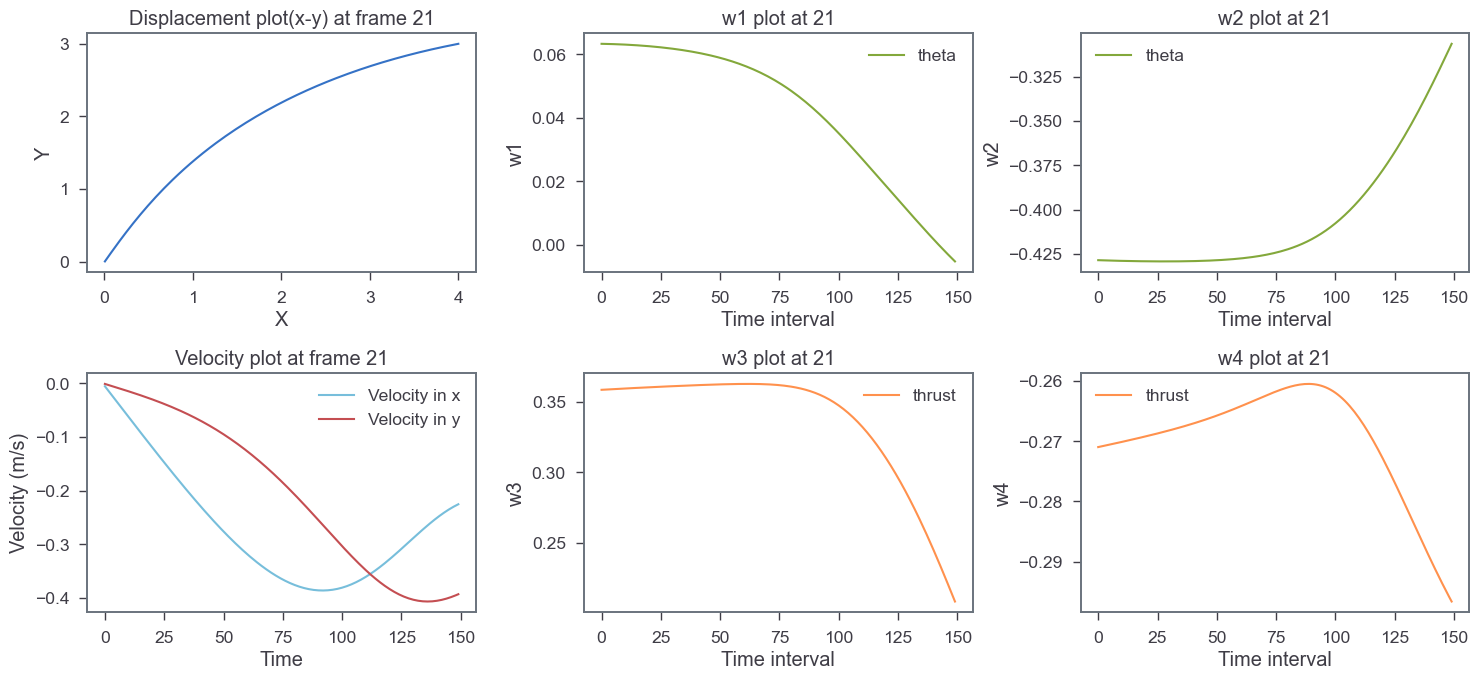

[23] loss: 0.068


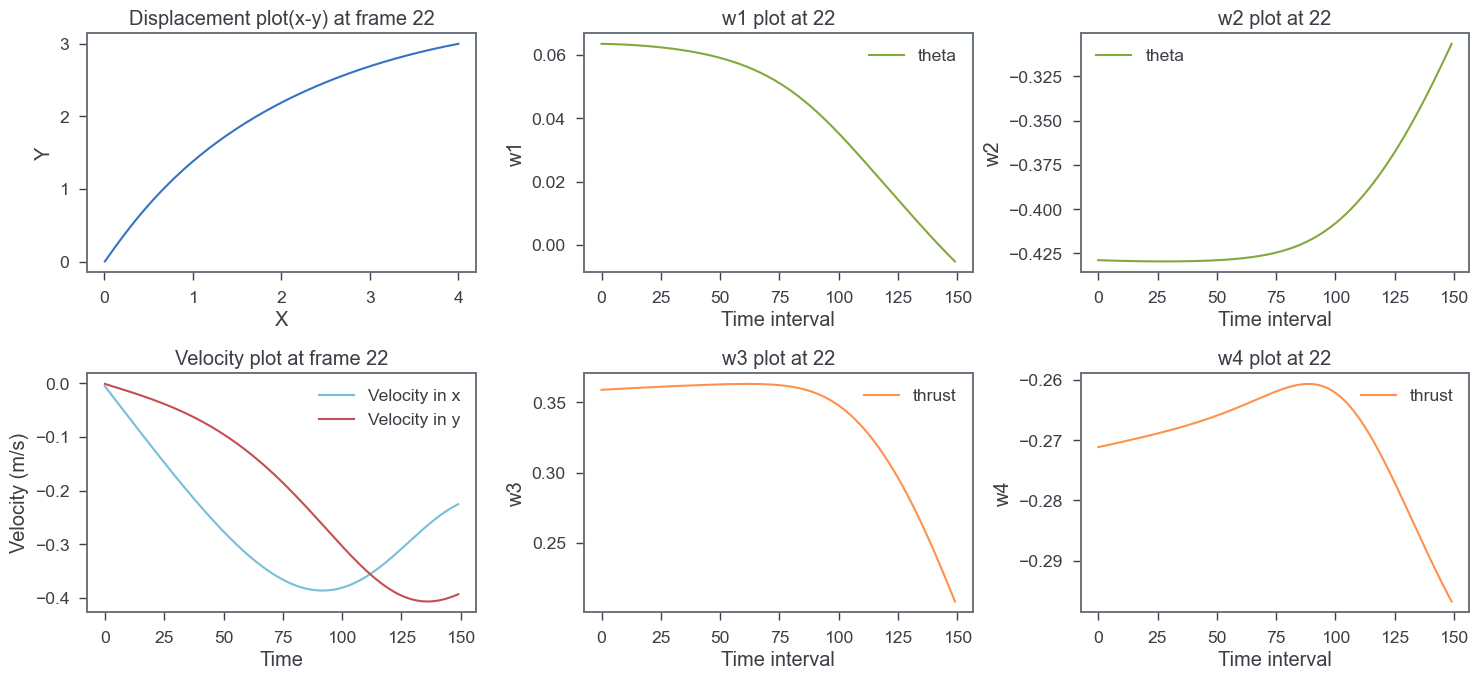

[24] loss: 0.067


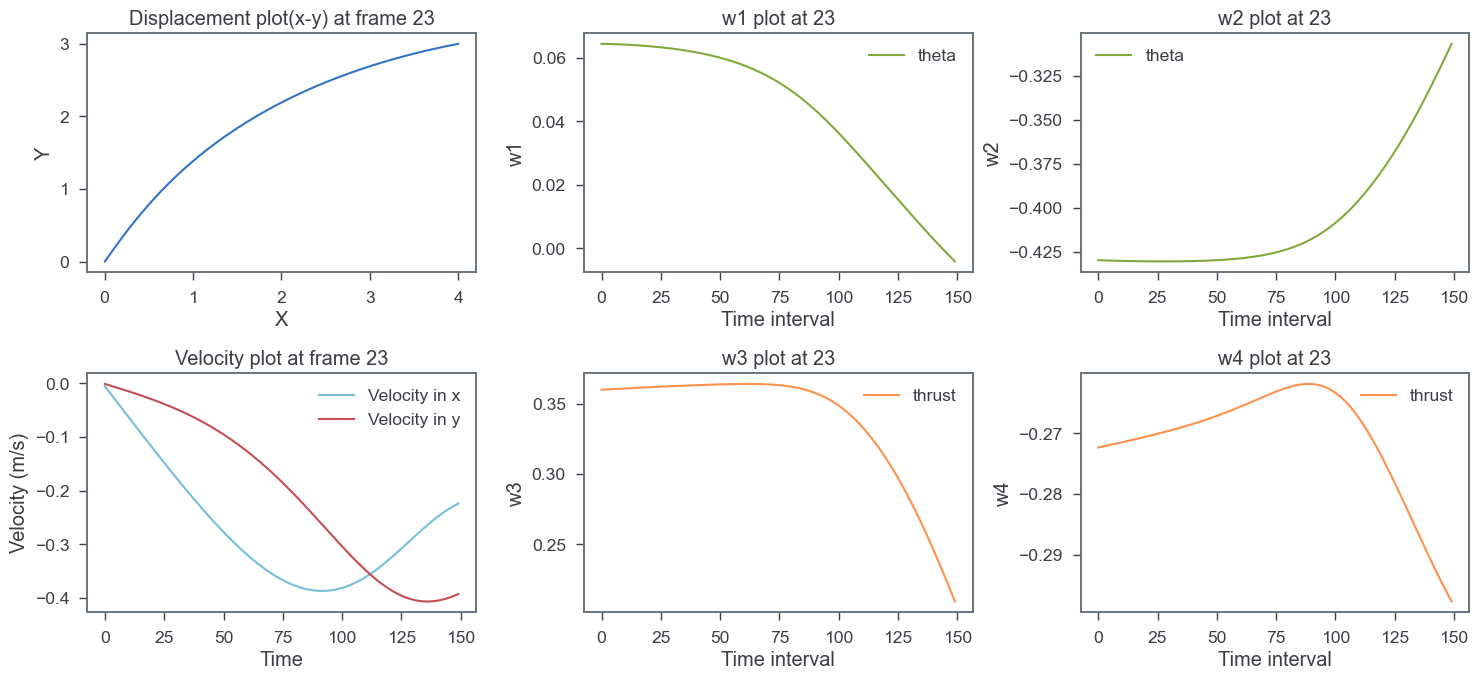

[25] loss: 0.067


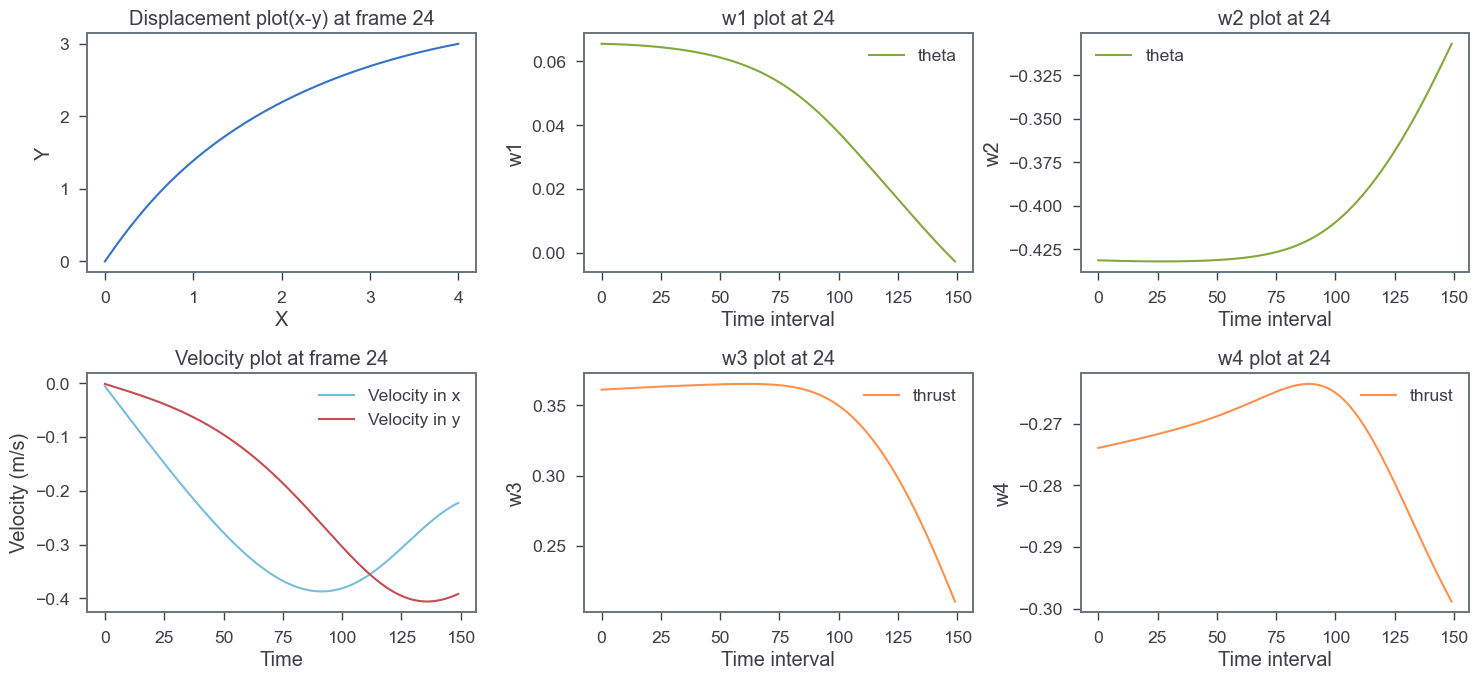

[26] loss: 0.067


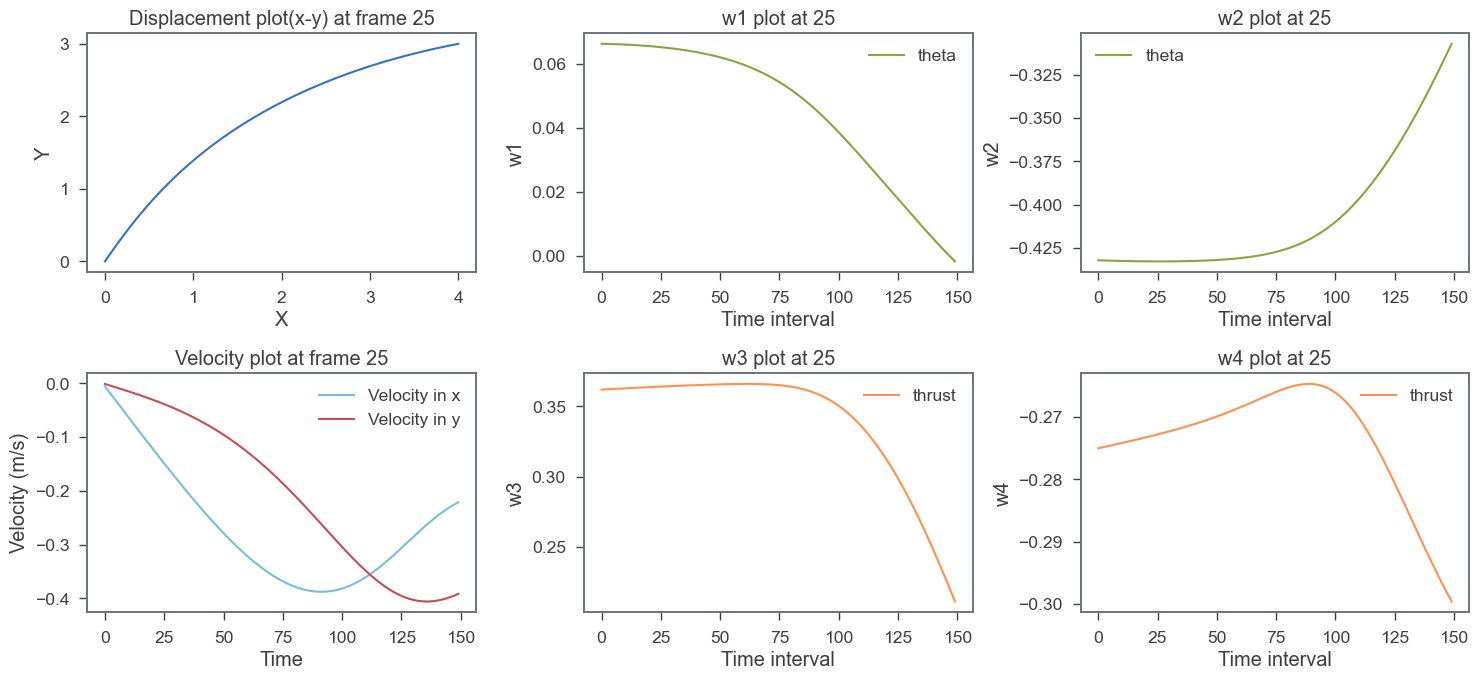

[27] loss: 0.066


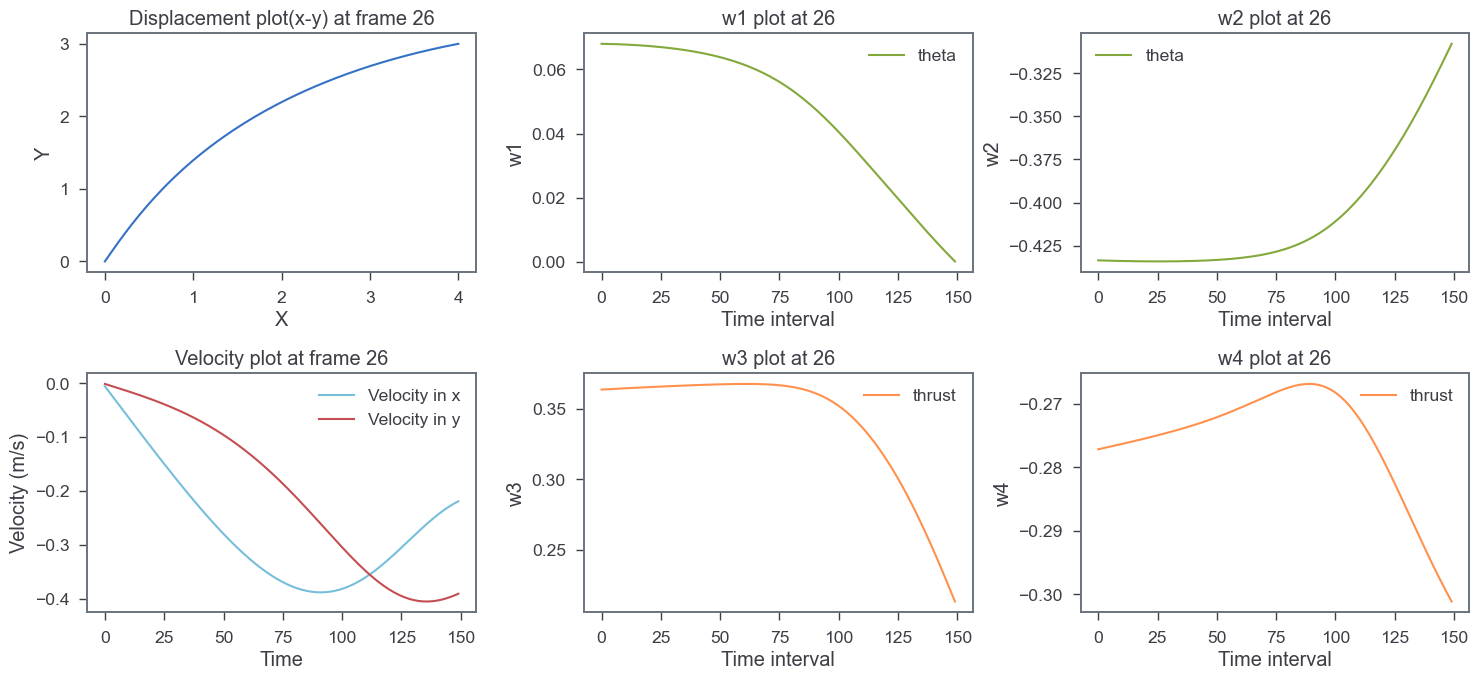

[28] loss: 0.064


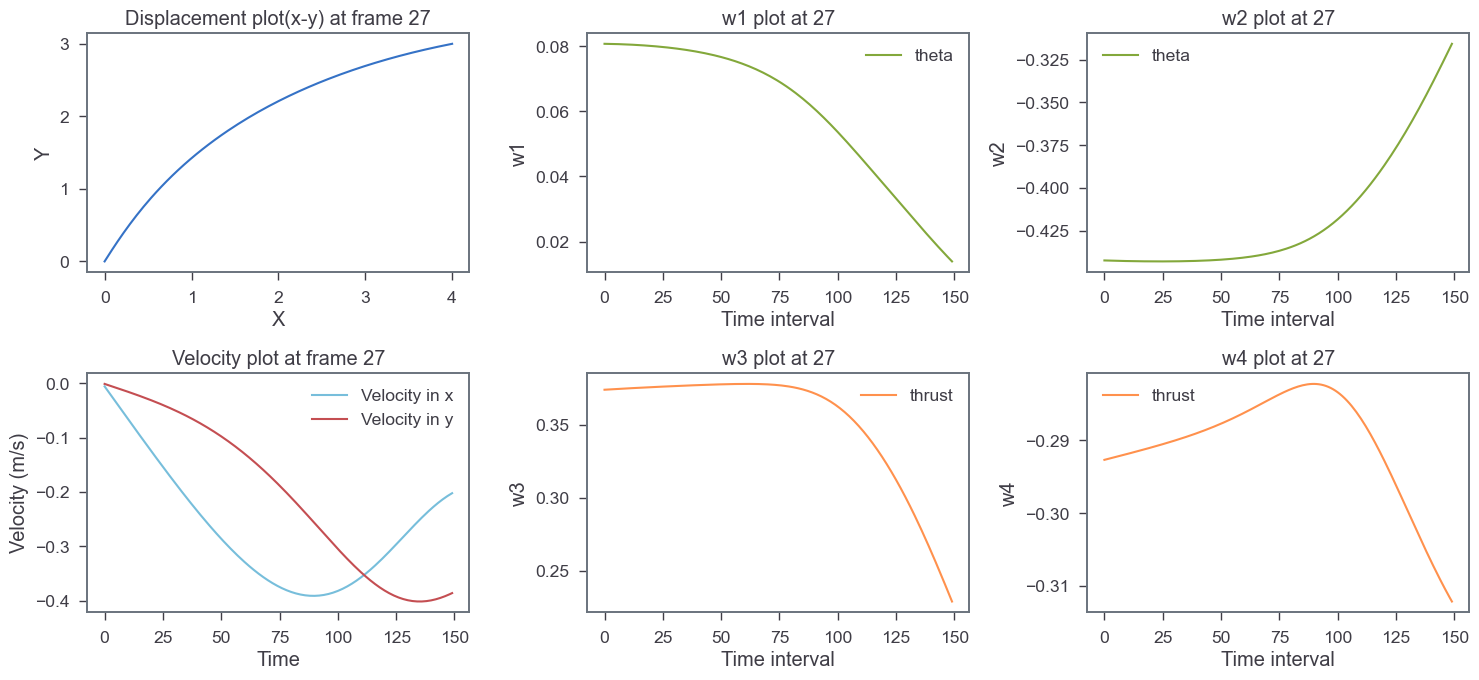

[29] loss: 0.055


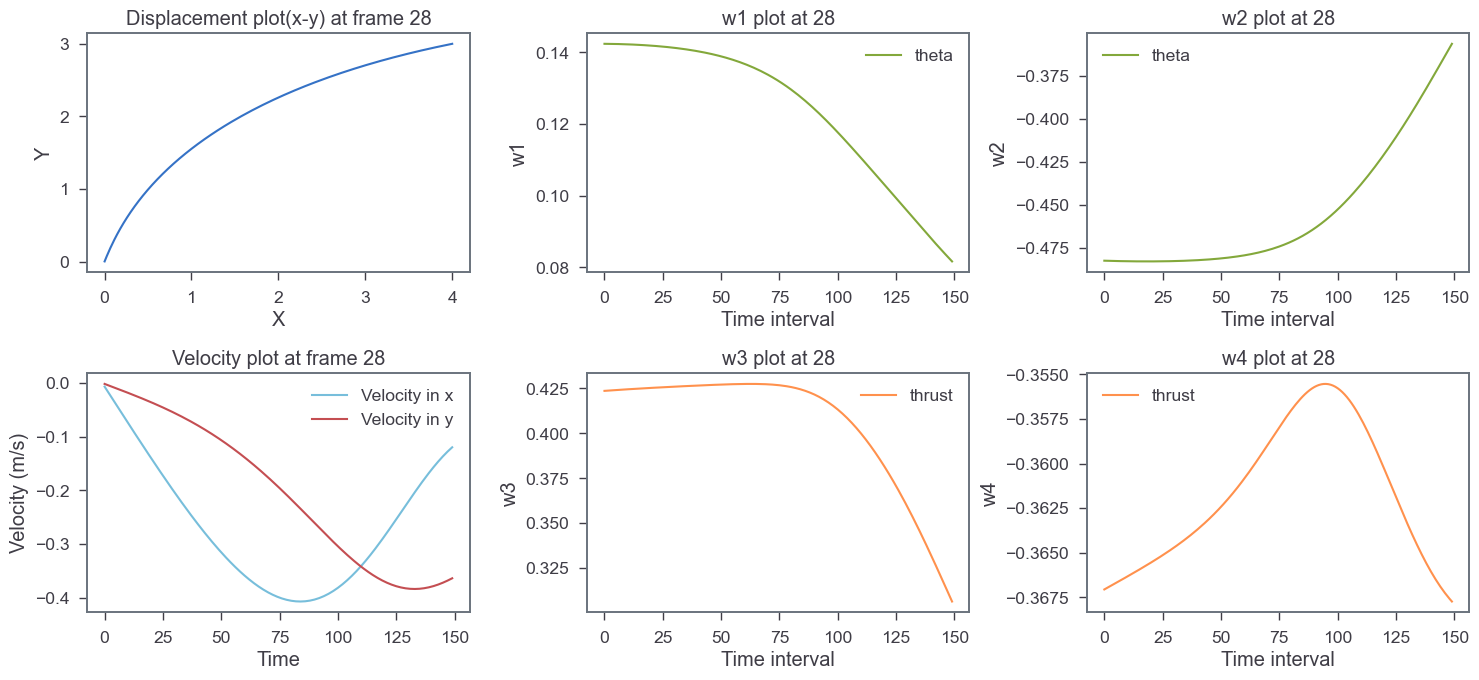

[30] loss: 0.080


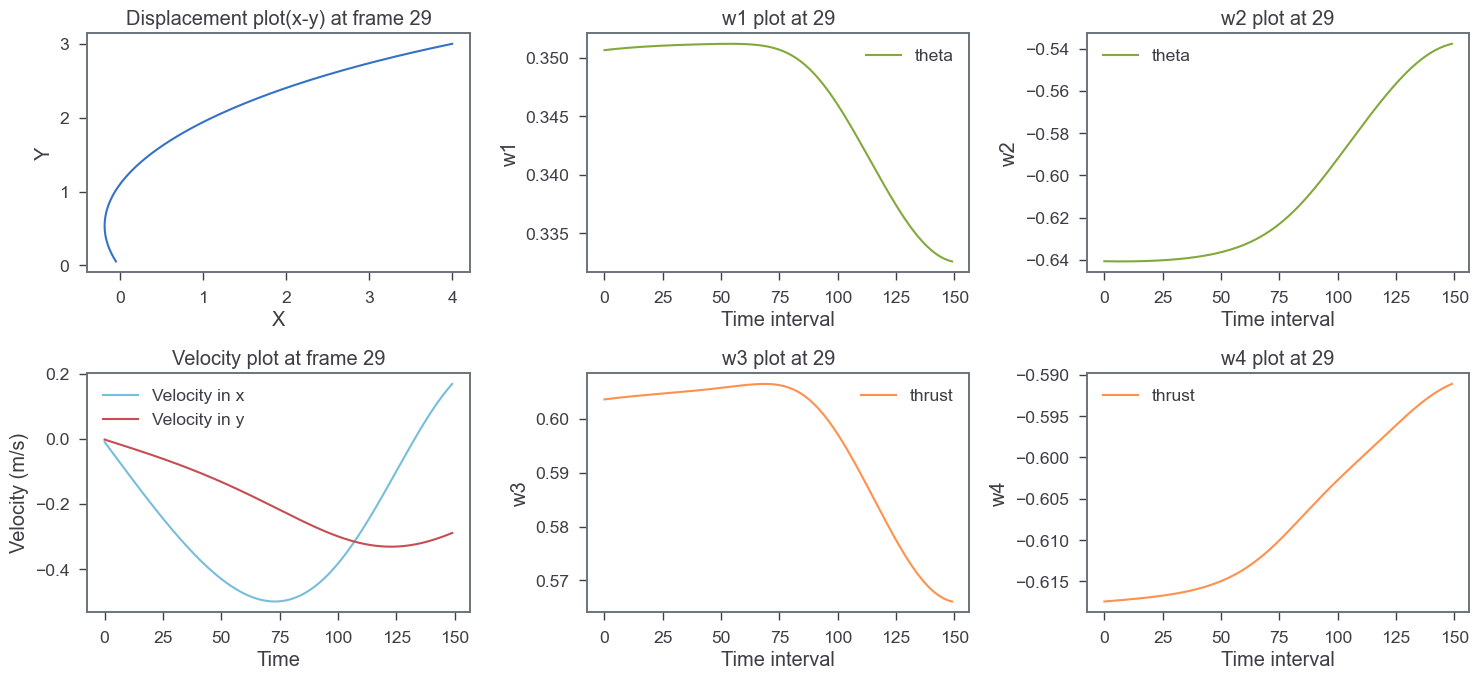

[31] loss: 0.077


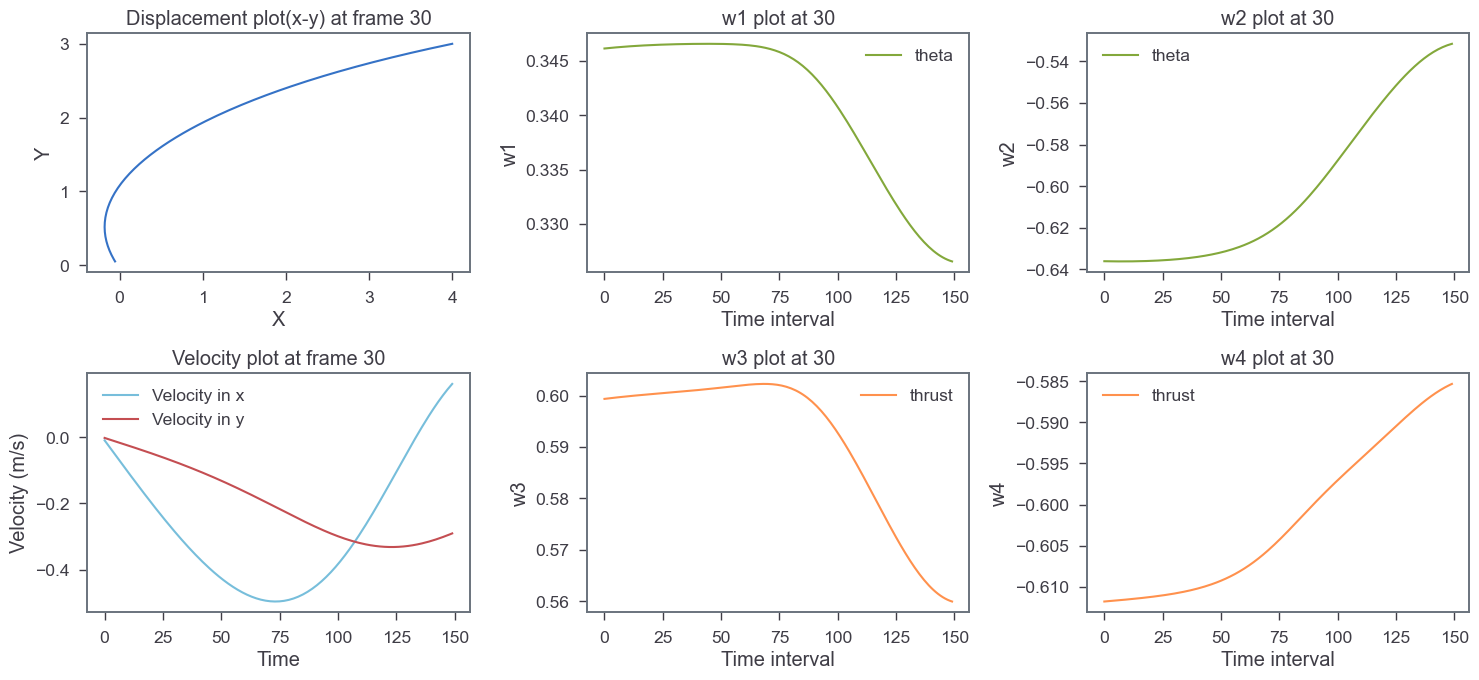

[32] loss: 0.077


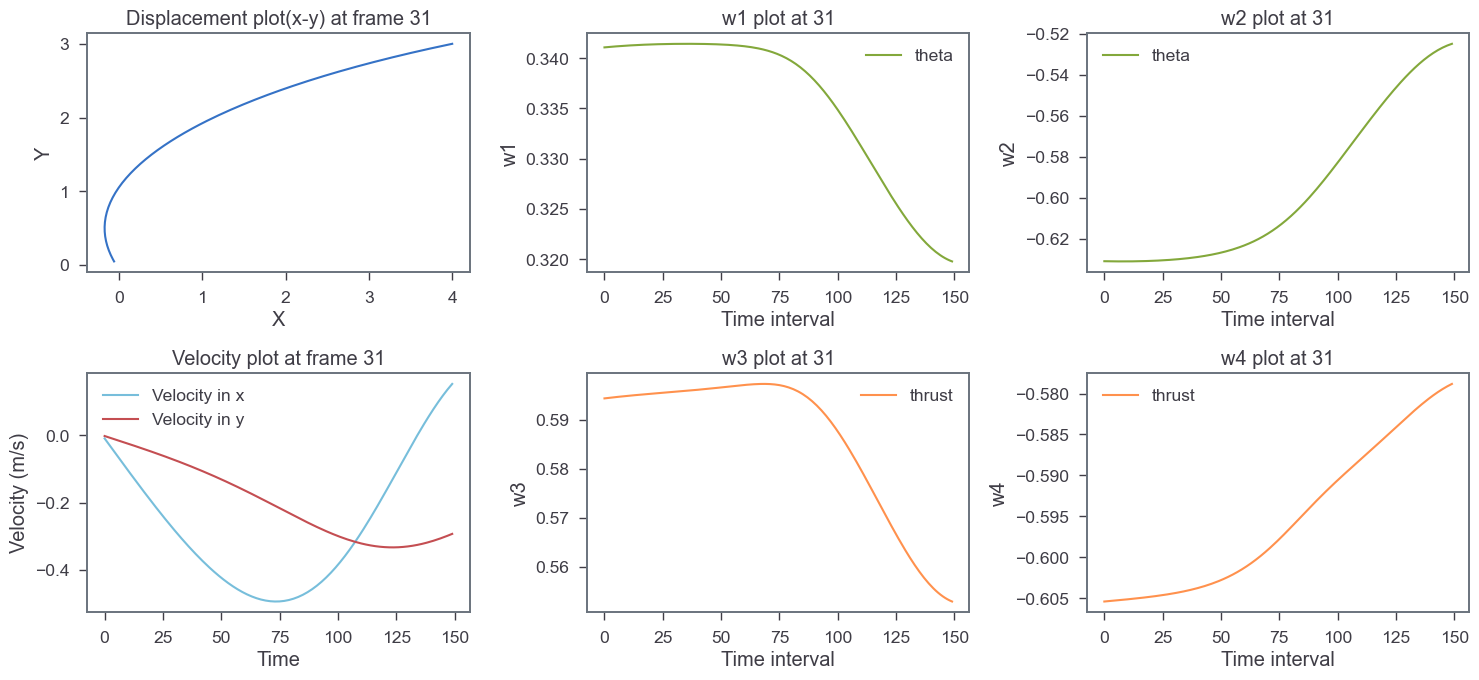

[33] loss: 0.078


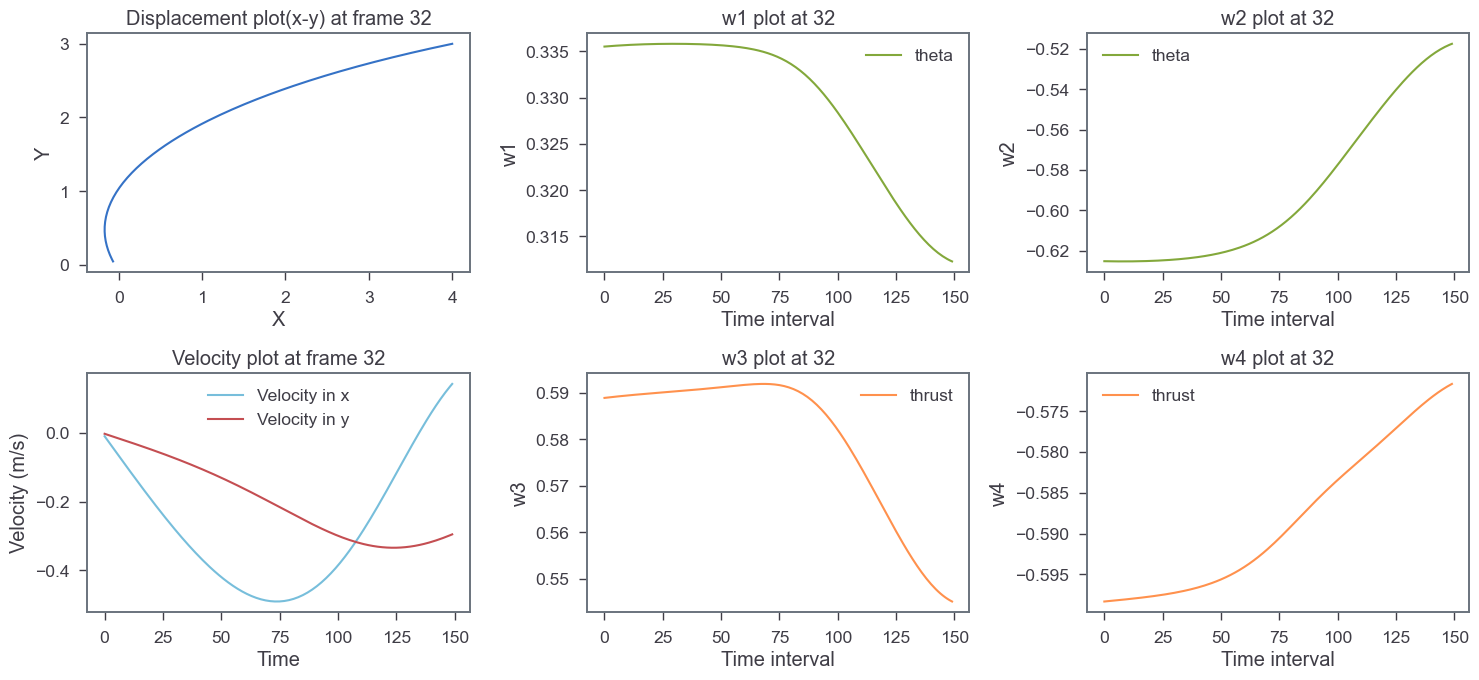

[34] loss: 0.080


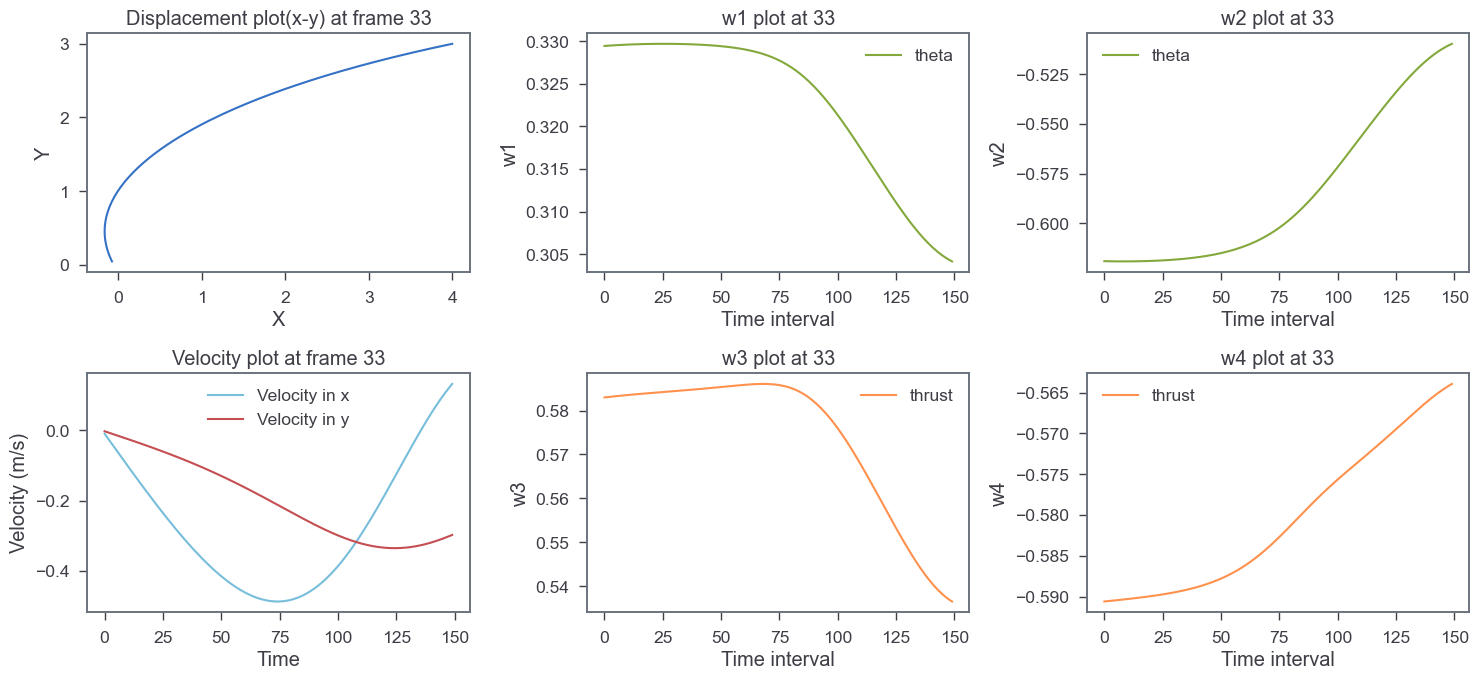

[35] loss: 0.084


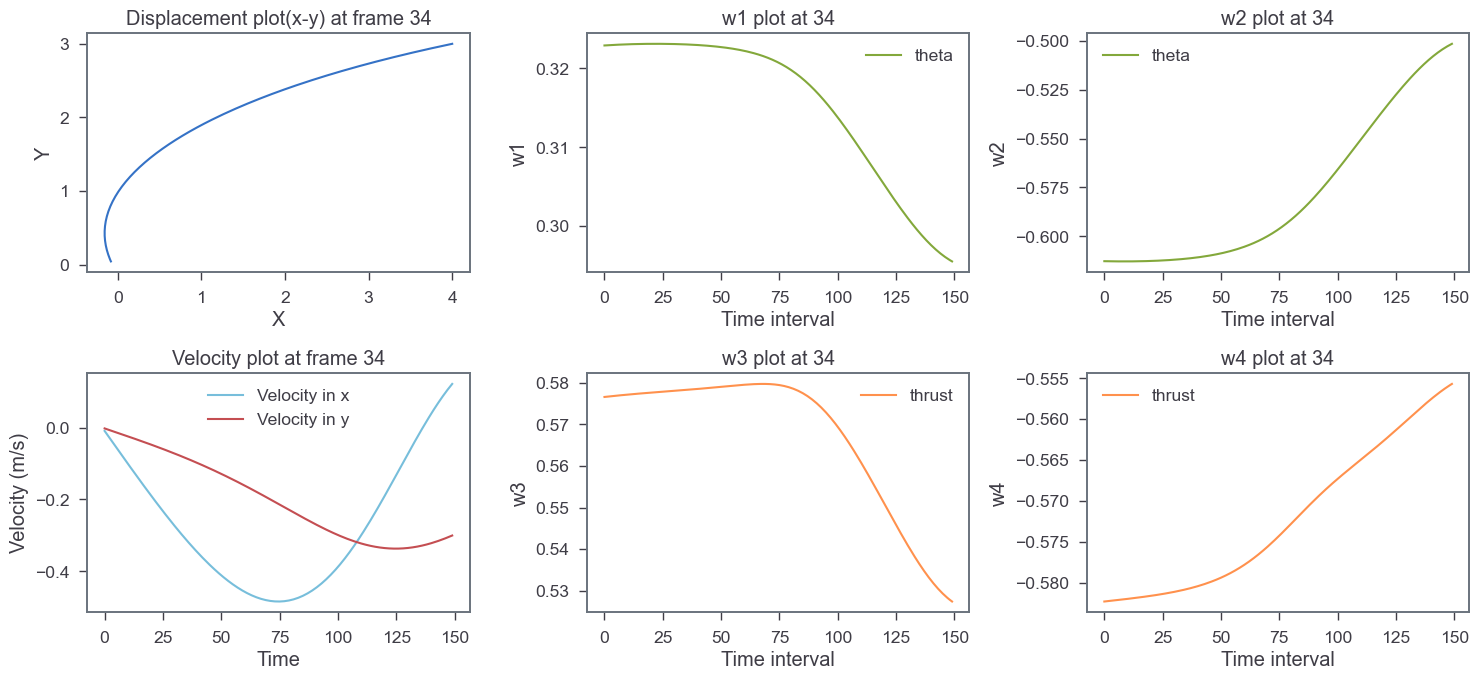

[36] loss: 0.089


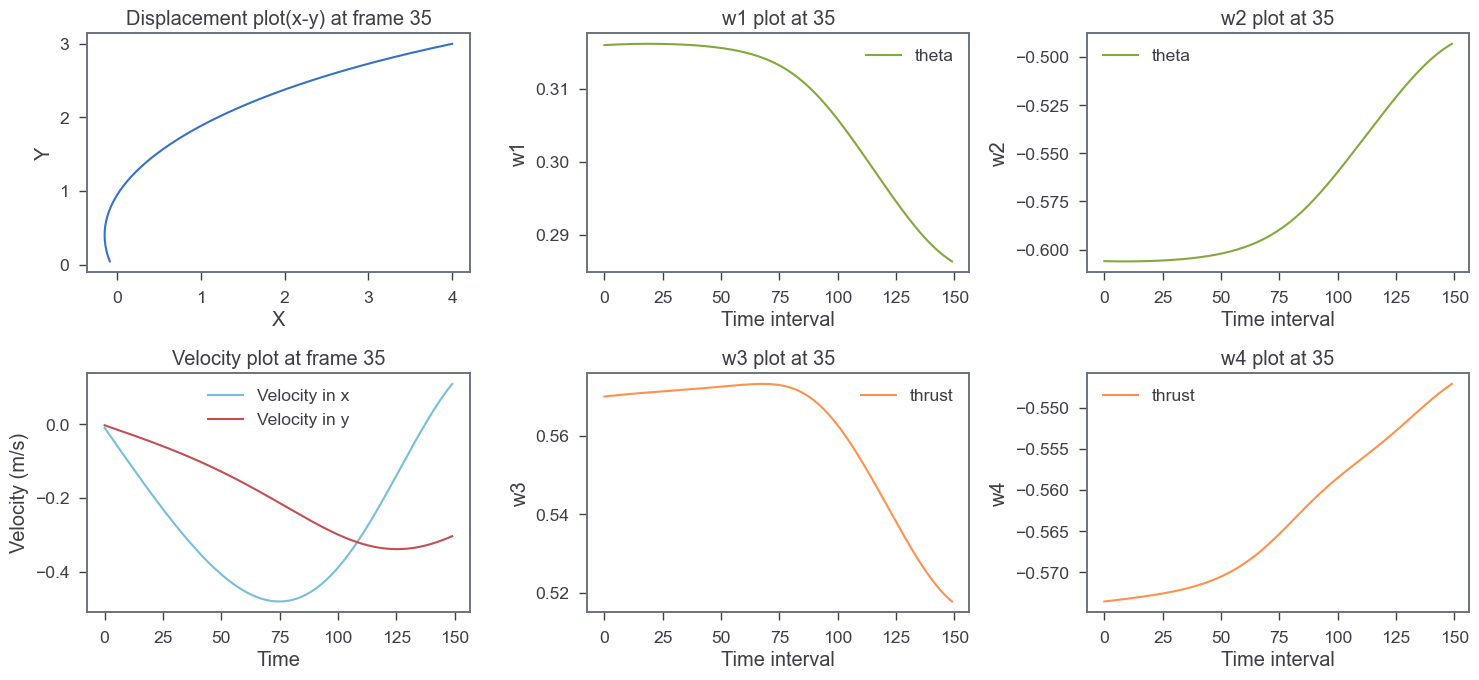

[37] loss: 0.095


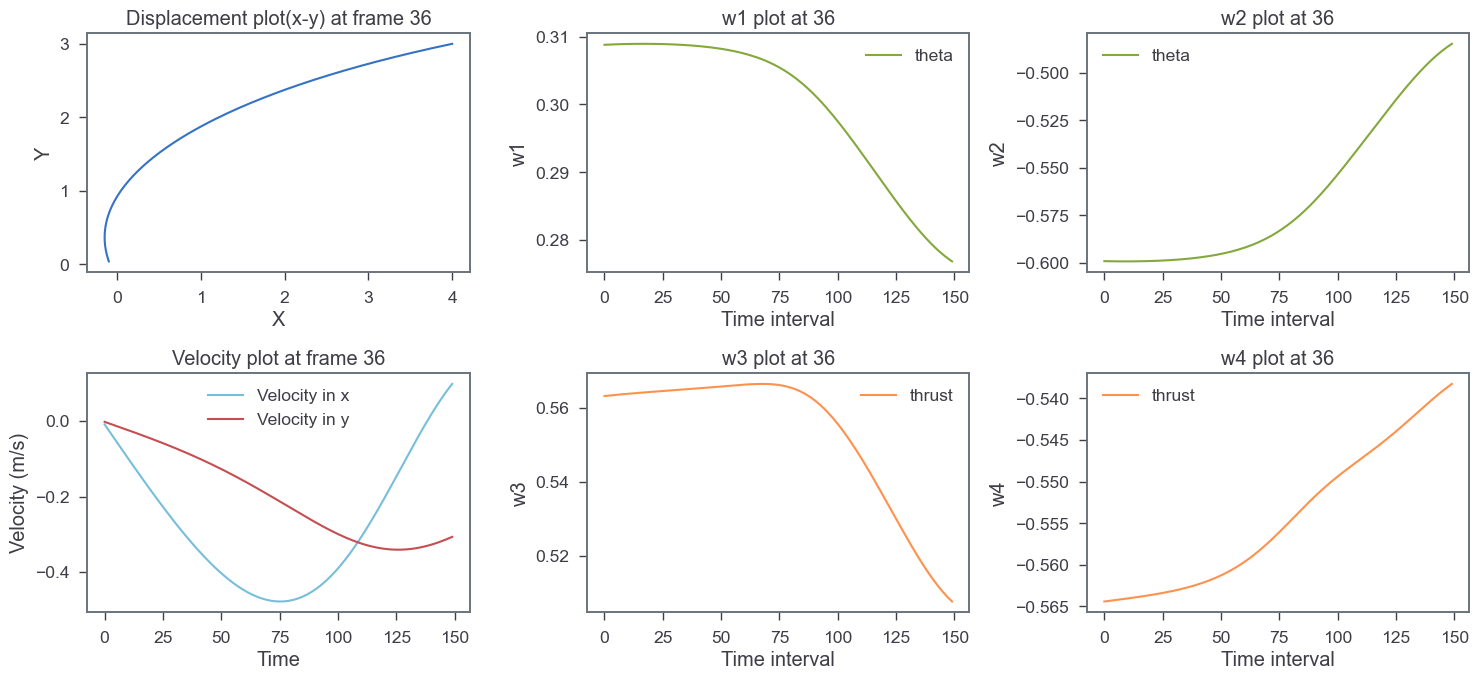

[38] loss: 16.438


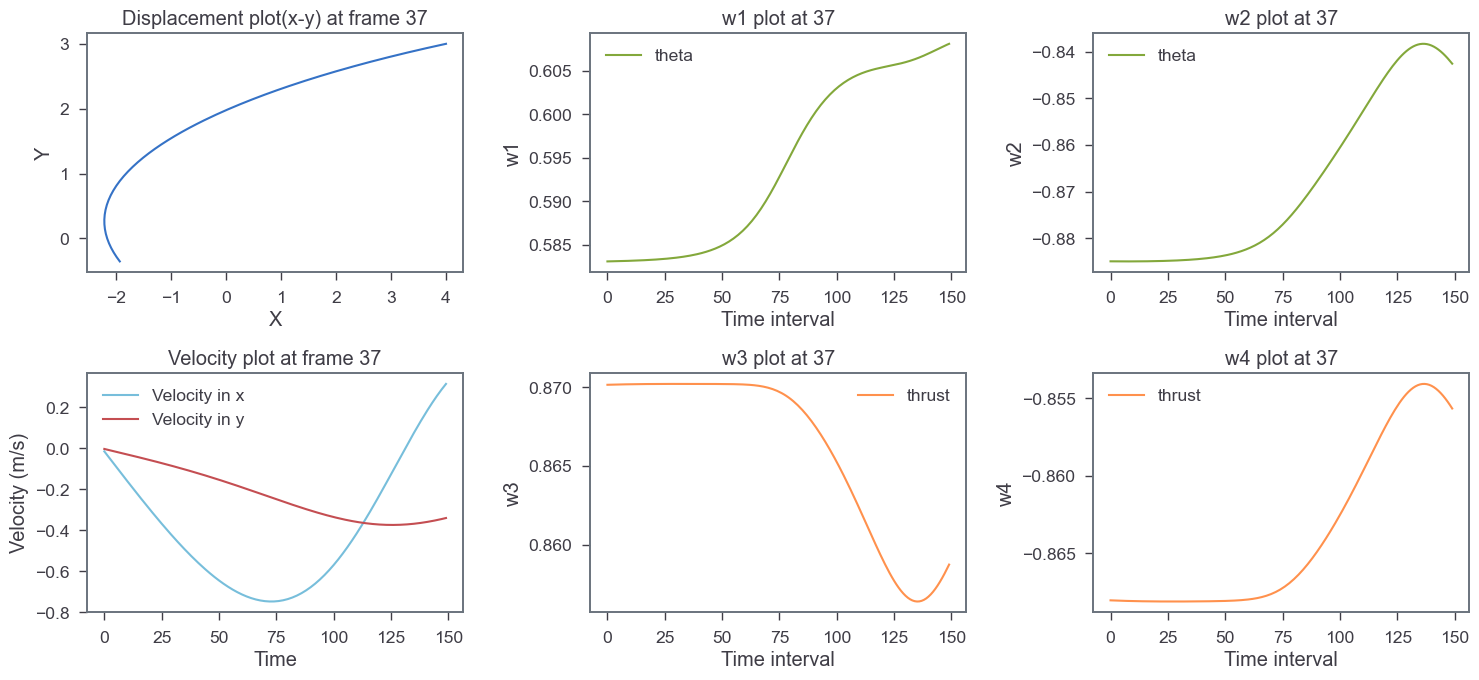

[39] loss: 37.331


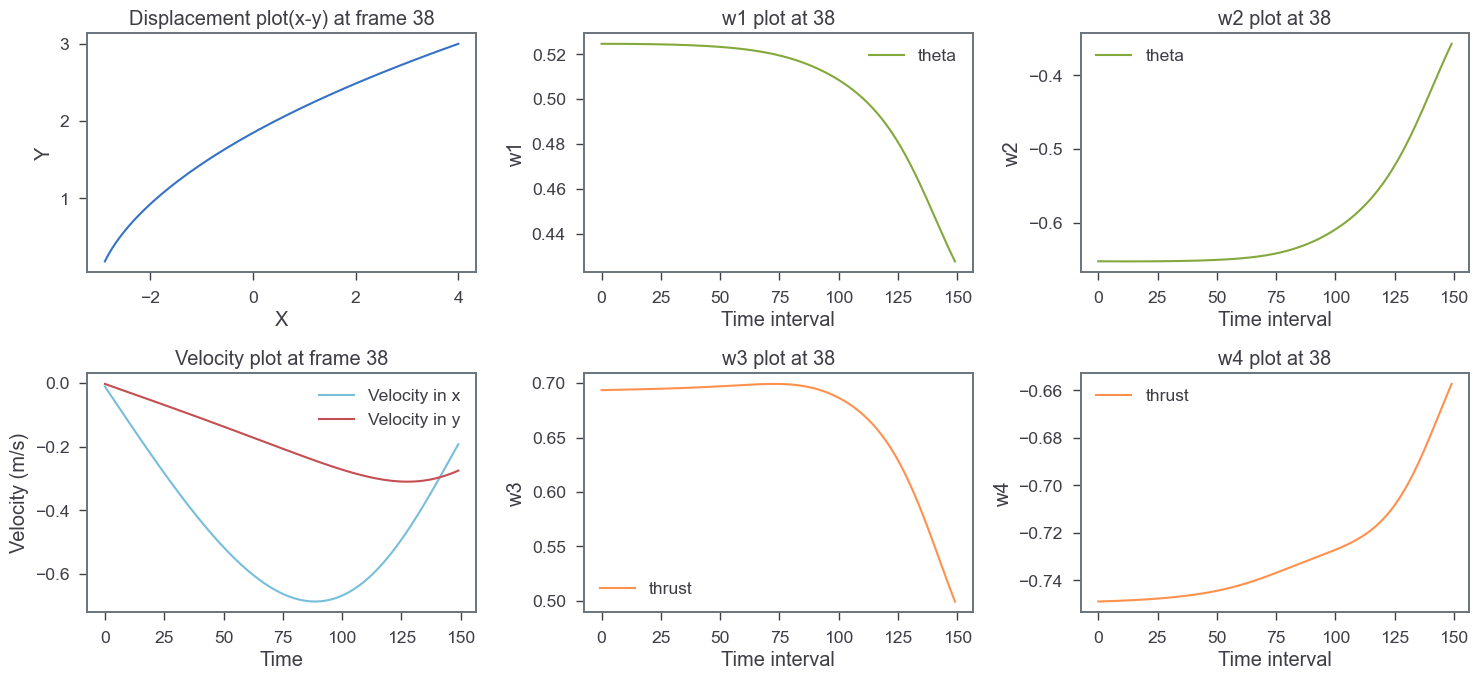

[40] loss: 21.994


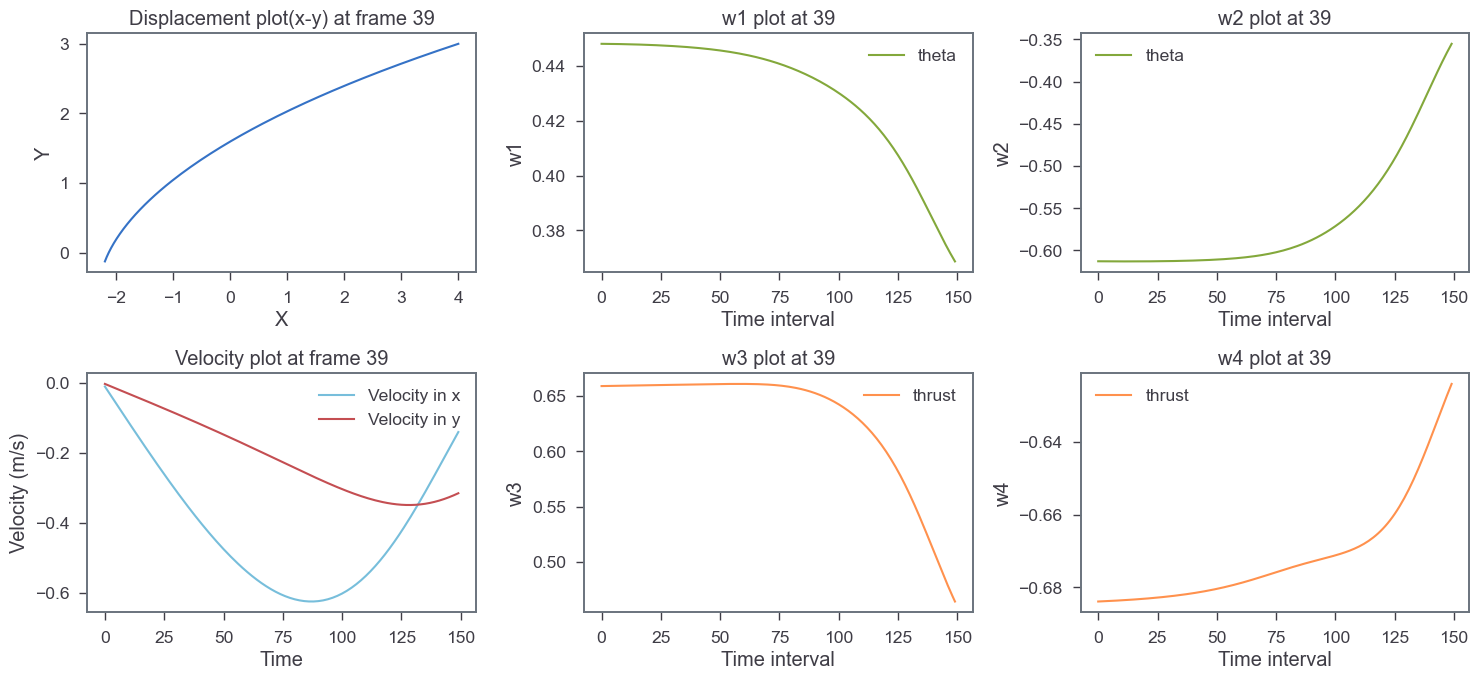

[41] loss: 11.750


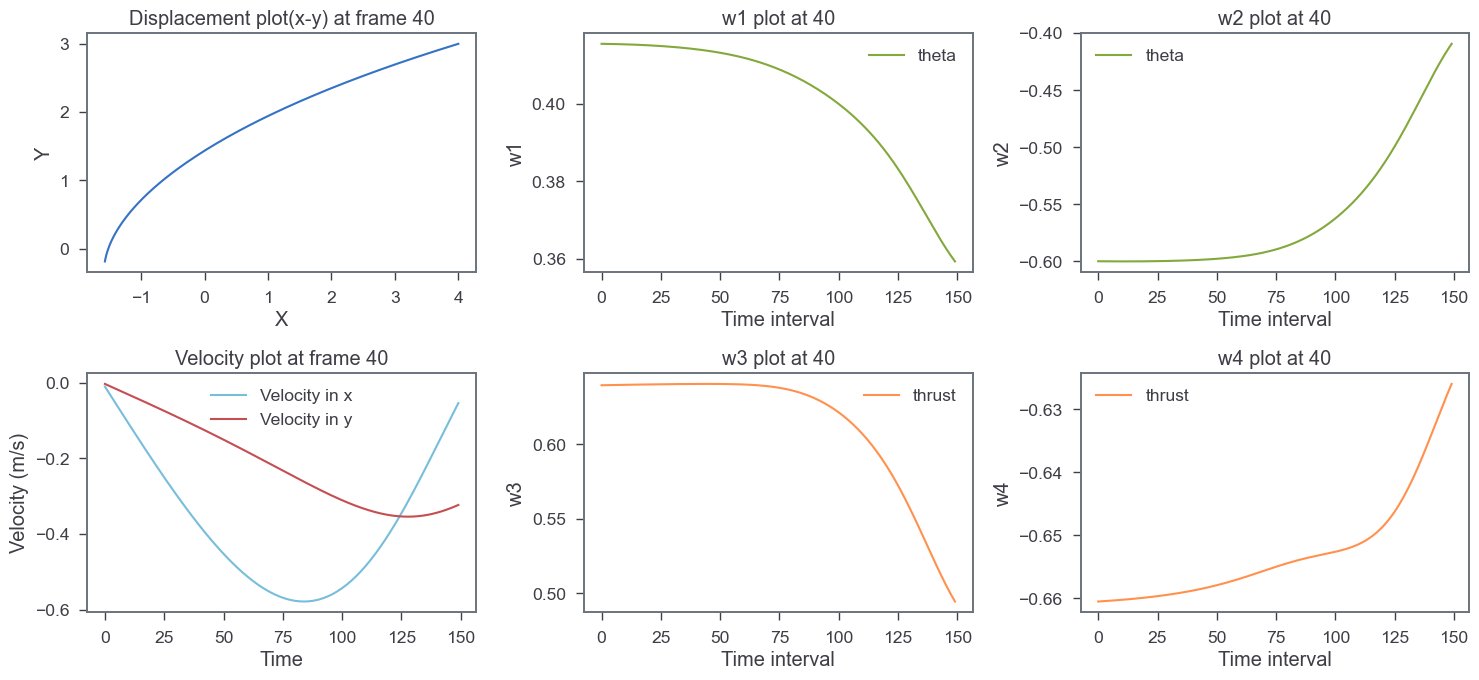

[42] loss: 6.582


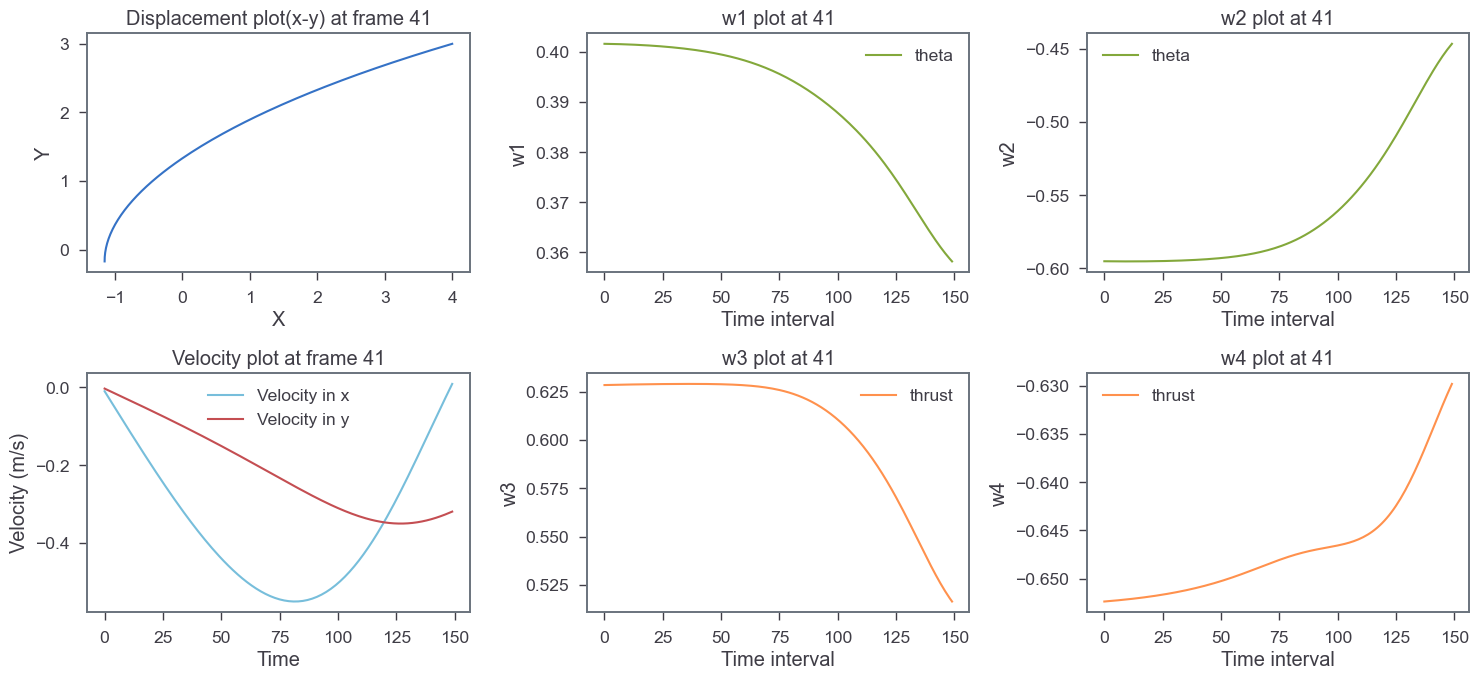

[43] loss: 3.895


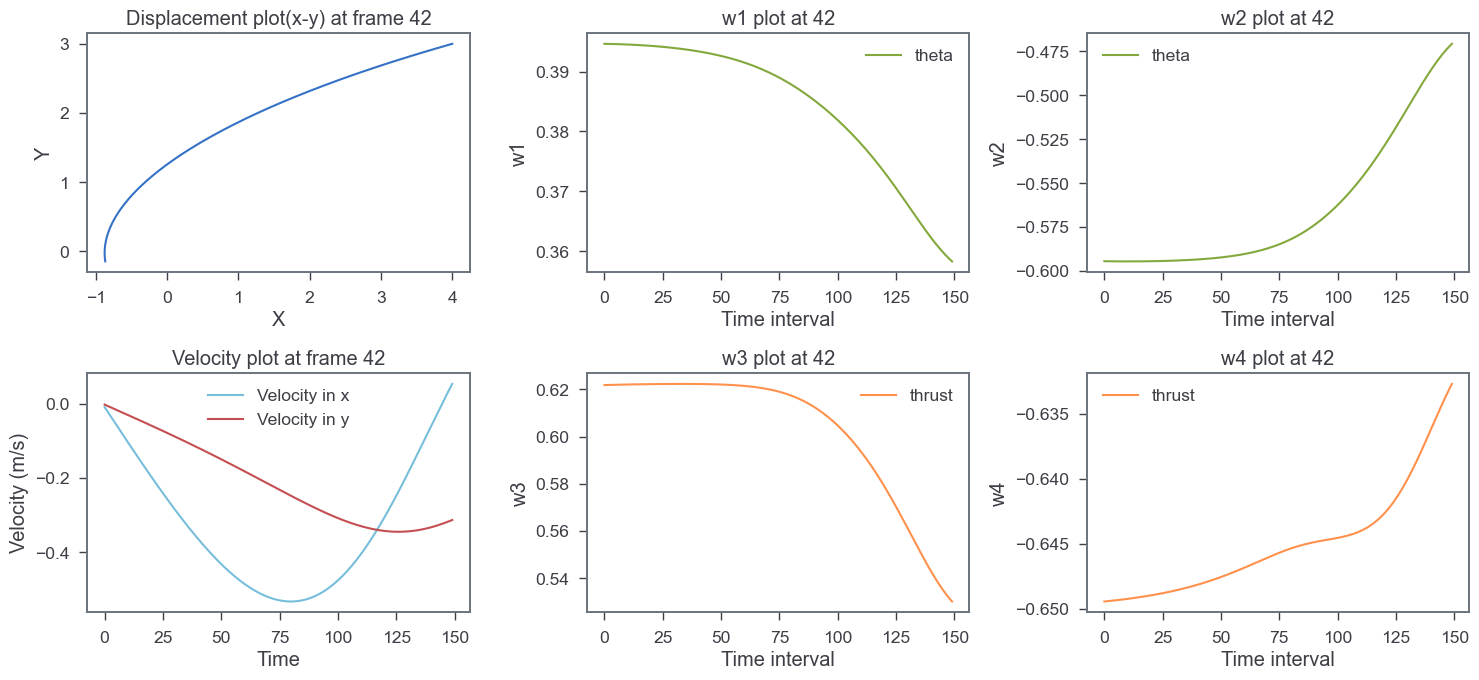

[44] loss: 2.357


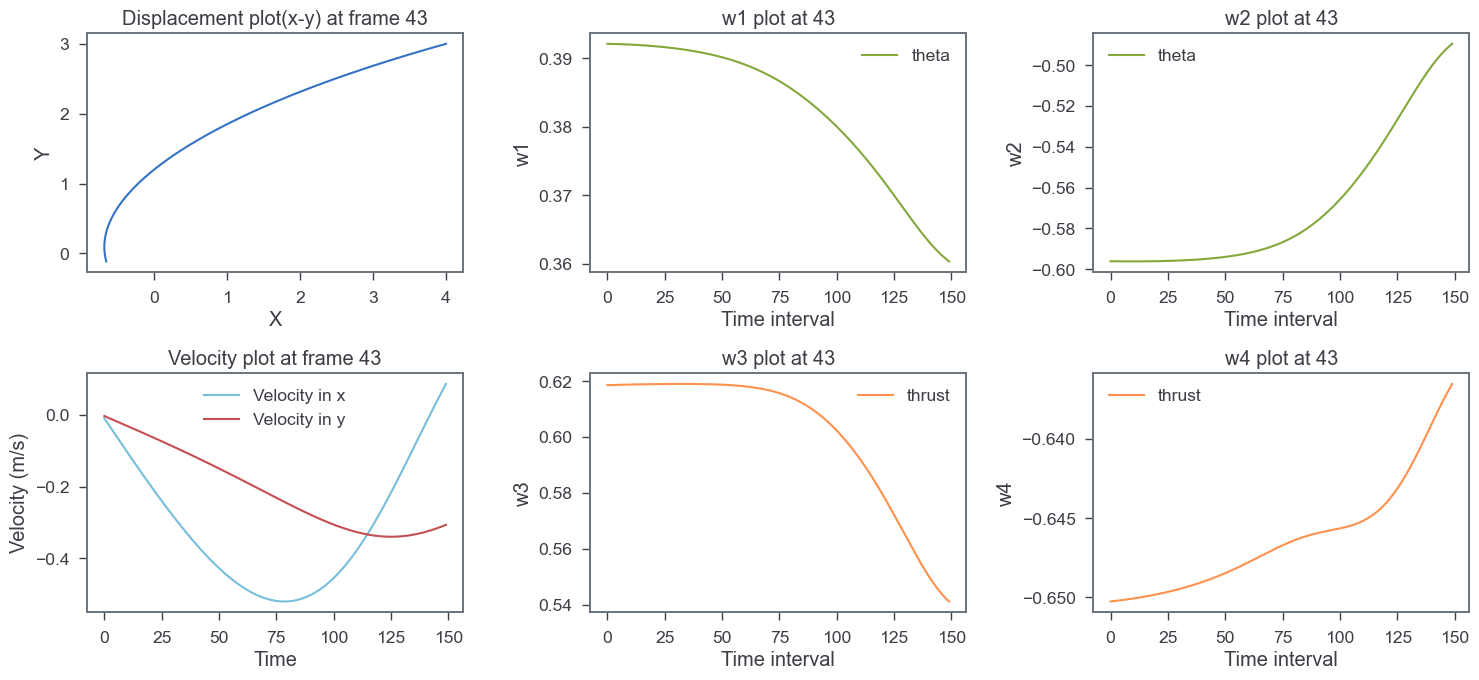

[45] loss: 1.380


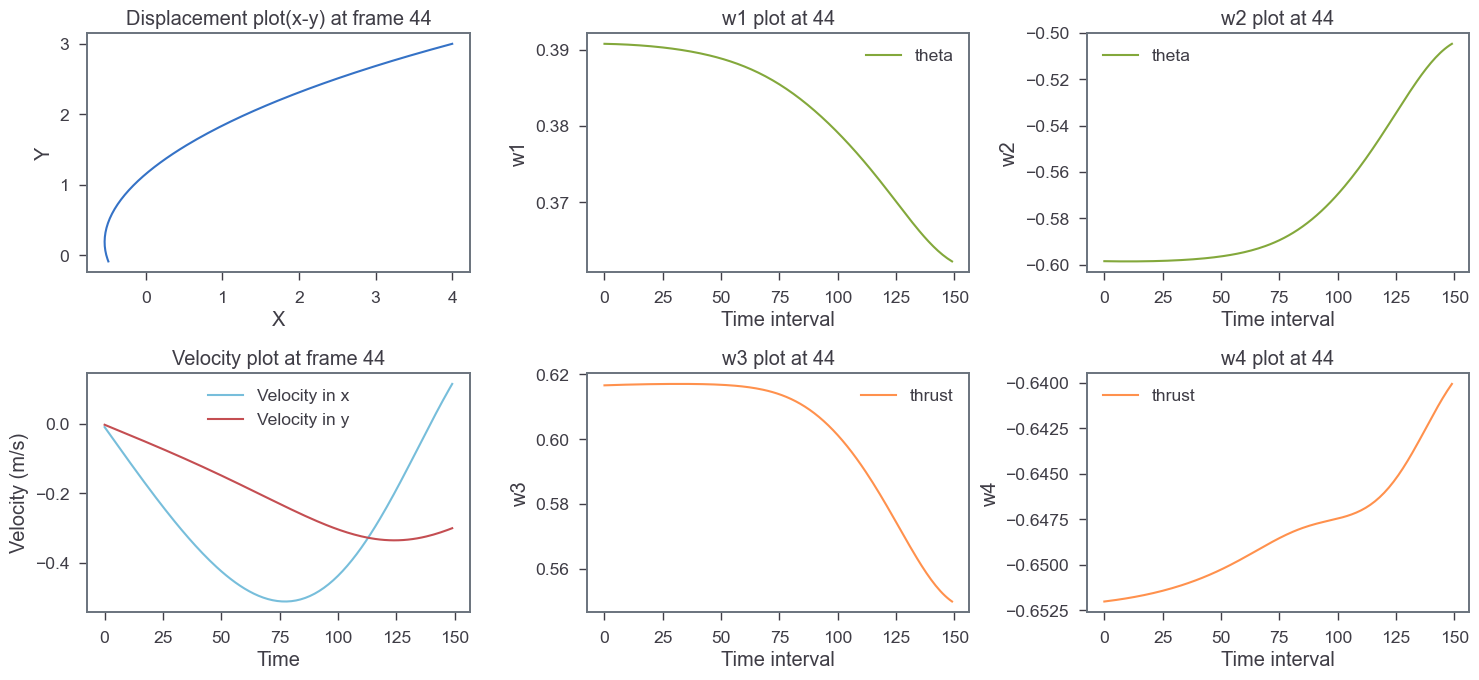

[46] loss: 0.732


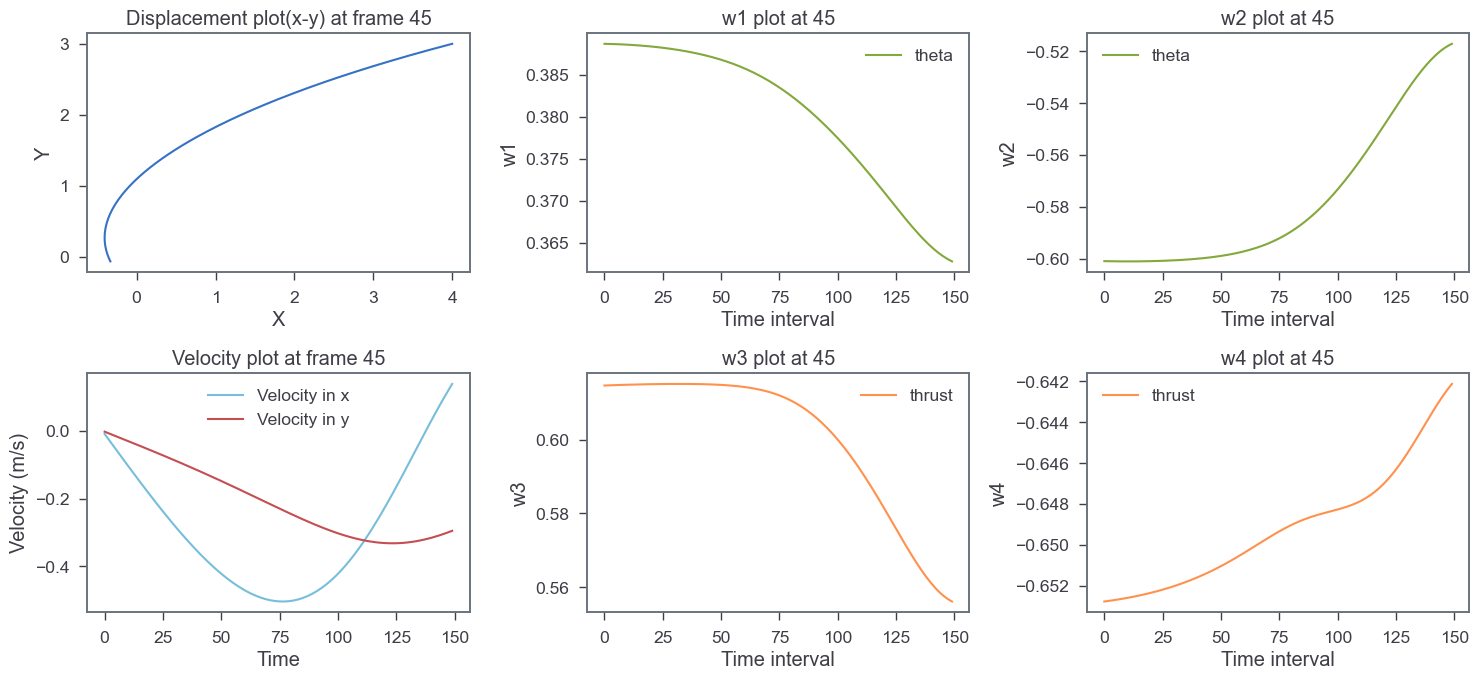

[47] loss: 0.304


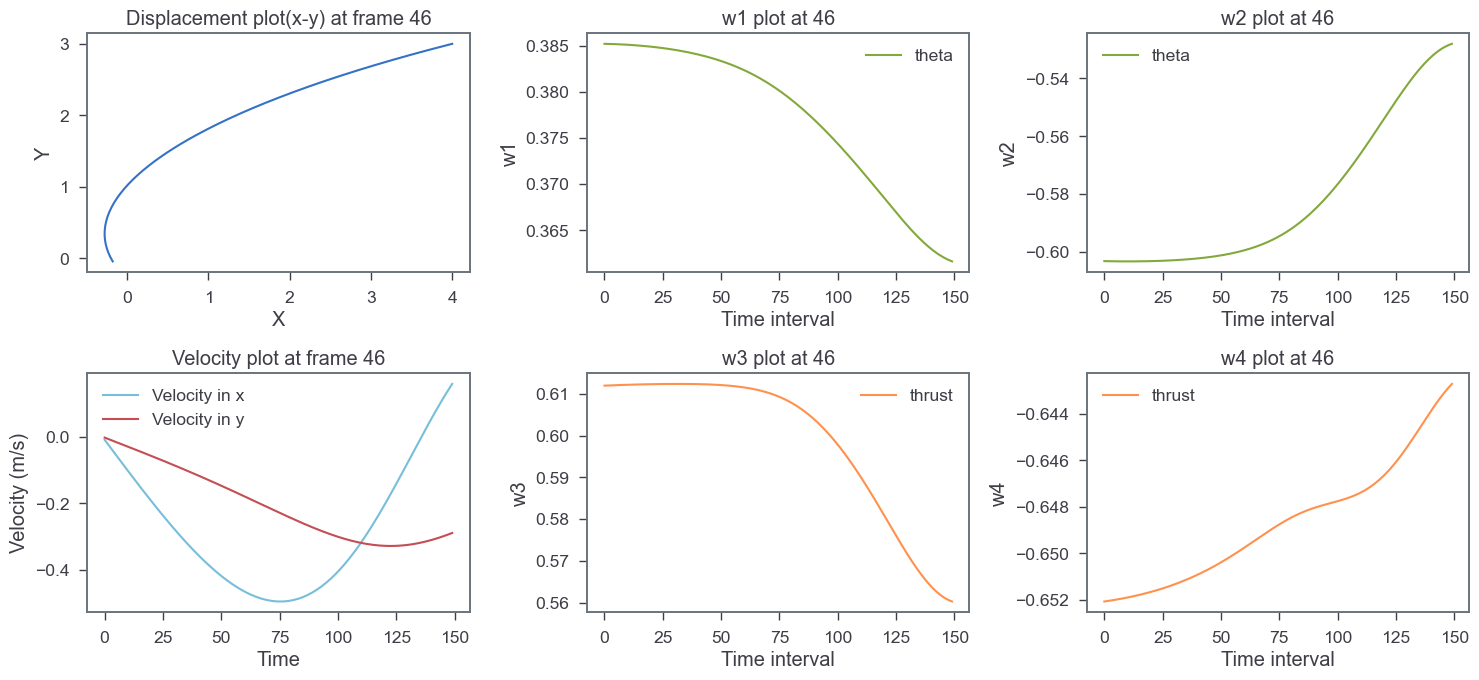

[48] loss: 0.092


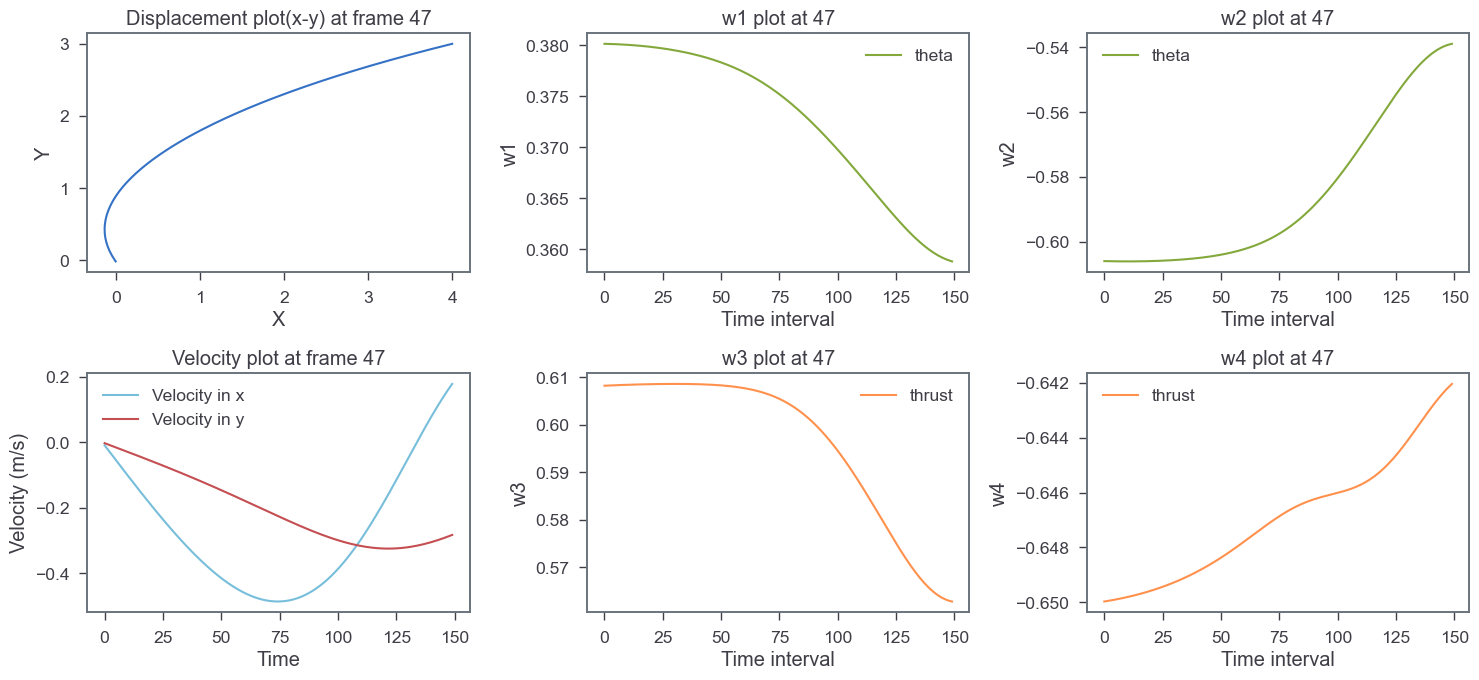

[49] loss: 0.196


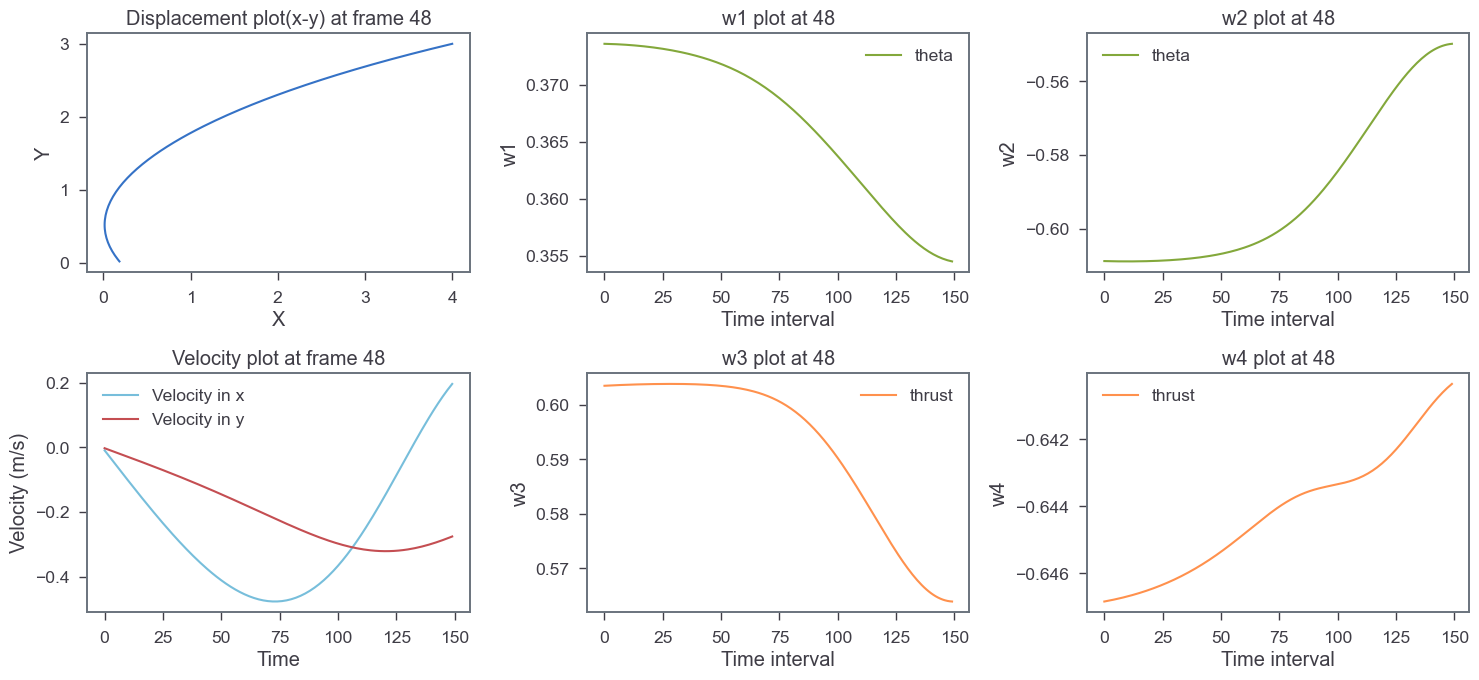

[50] loss: 0.679


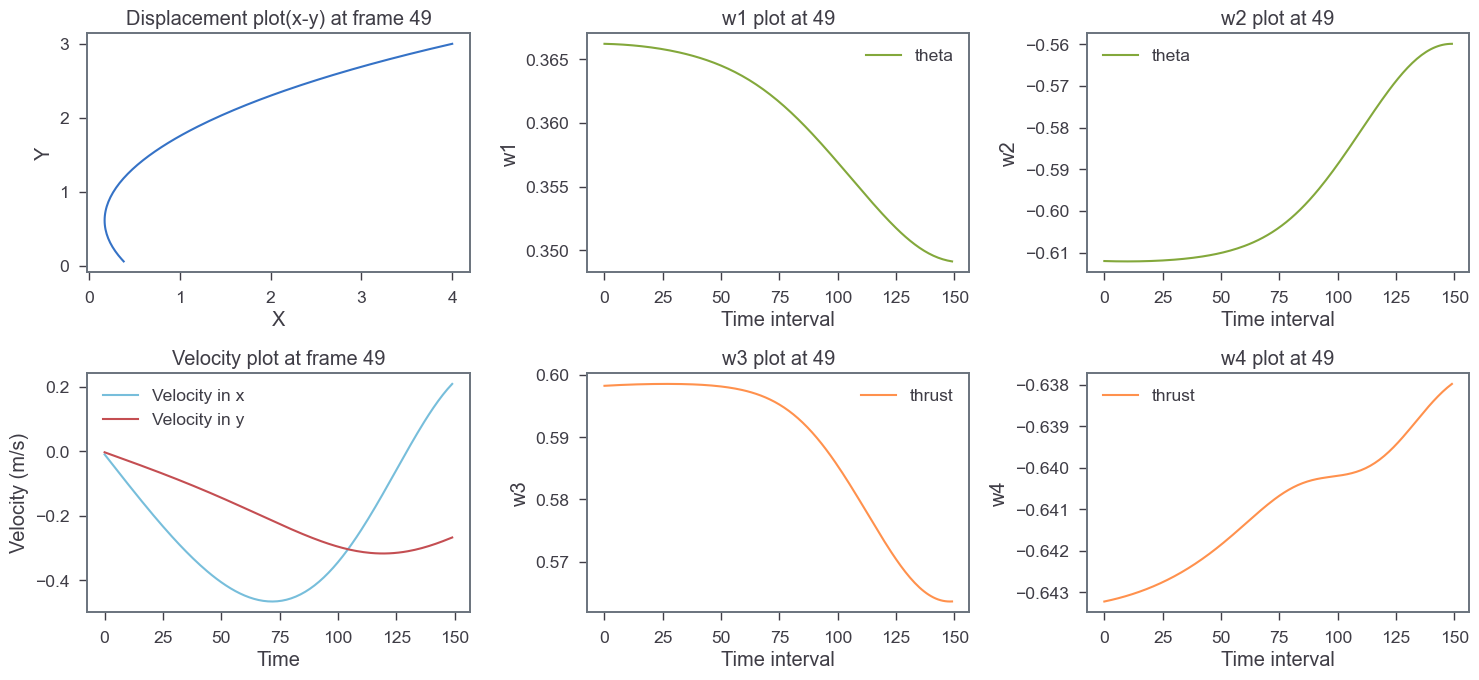

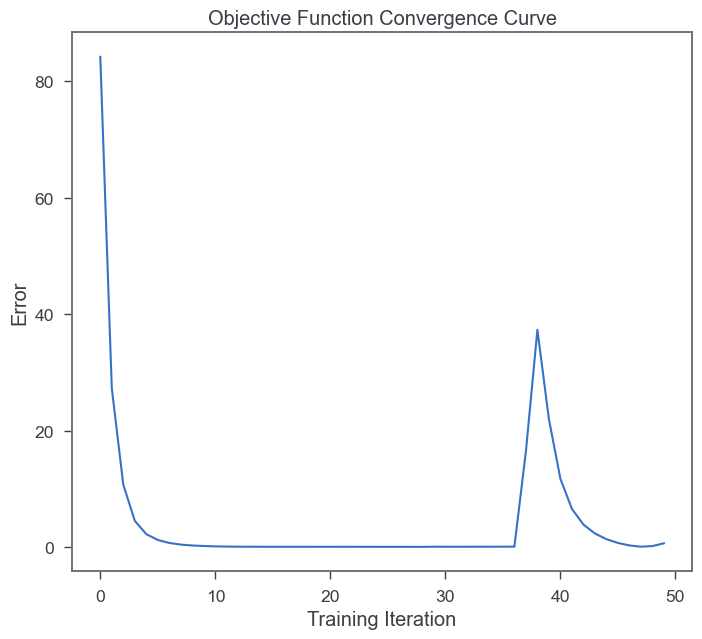

Generating Animation


IntProgress(value=0, max=151)

(150, 6) (150, 4)


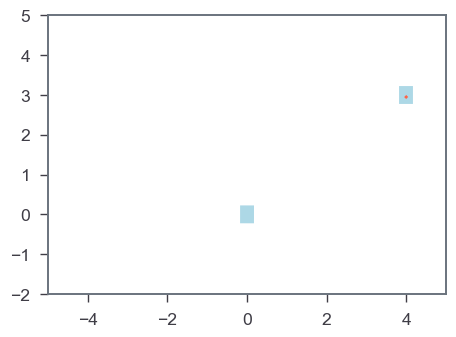

In [682]:
T = 150  # Number of time steps of the simulation
dim_input = 6  # State space dimensions
dim_hidden = 6 # Latent dimensions
dim_output = 4  # Action space dimensions

# Final state for the simulation
fs = torch.tensor([[0.,0.,0.,0.,0.,-3.14]]) 

# Create instances of the Dynamics, Controller, Simulation, and Optimize classes
d = Dynamics()   # Dynamics model for updating the robot's state
c = Controller(dim_input, dim_hidden, dim_output)   # Controller model for generating actions
s = Simulation(c, d, T)  # Simulation model combining the controller and dynamics
o = Optimize(s)  # Optimization model for training the controller

# Train the controller using optimization (gradient descent)
o.train(50)  # Training with a specified number of epochs (gradient descent steps)

Generating Animation


IntProgress(value=0, max=151)

(150, 6) (150, 4)


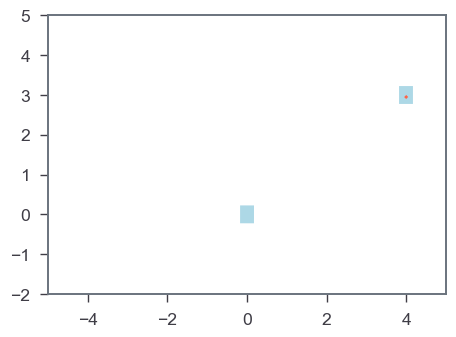

In [683]:
# o.Animation_Only()

## 4. Grading

* (20%) **Documentation of the problem formulation**: Clearly describe the objective function, the variables, the constraints (including the dynamical systems involved), and the assumptions involved in formulating the problem.

* (30%) **Programming**: Please push you code to your github repo or a deepnote notebook. Please comment your code so that it is useful to you in the future.

* (30%) **Analysis of the results**: Please explain clearly and in details all issues you encountered and lessons you learned in solving your problem, including incorrect problem formulations, hyperparameter tuning (e.g., for the optimization algorithm), and coding issues (e.g., related to tensor operations).

* (20%) **Visualization**: Once you find a converged solution, please do your best to visualize the final results in video and other necessary formats so that other people can easily understand what you achieved. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=59115d46-a419-43f9-a3fe-b160aca2a335' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>